# Libraries installation

In [1]:
# !pip uninstall torch torchvision torchaudio -y
# !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117
# !pip install mne -q
# !pip install wandb -q
# !pip install tensorboard -q

# Constants and libraries

In [2]:
'''
In this section one defines environment variables. 
Because I used this notebook on number of machines, I implemented class especially for this. 
You may not needed in one and use just simple definitions.
'''

from system_variables import SystemVariables

# choose system according your current machine
# SYSTEM_NAME = "Windows"
# SYSTEM_NAME = "Colab"
# SYSTEM_NAME = "Kaggle"
SYSTEM_NAME = "Linux"

sv = SystemVariables(SYSTEM_NAME)
PROJECT_FOLDER = sv.get_project_folder()
SRC_FOLDER = sv.get_src_folder()
OUTPUT_FOLDER = sv.get_output_folder()
TUAB_DIRECTORY, TUAB_TRAIN, TUAB_EVAL = sv.get_TUAB_folders()
DEPR_ANON_DIRECTORY = sv.get_depr_anon_folder()
INHOUSE_DIRECTORY = sv.get_inhouse_folder()

print(SYSTEM_NAME)
print()

print(f"{PROJECT_FOLDER = }")
print(f"{SRC_FOLDER = }")
print(f"{OUTPUT_FOLDER = }")
print()

print(f"{TUAB_DIRECTORY = }")
print(f"{TUAB_TRAIN = }")
print(f"{TUAB_EVAL = }")
print()

print(f"{DEPR_ANON_DIRECTORY = }")
print()

print(f"{INHOUSE_DIRECTORY = }")
print()

Linux

PROJECT_FOLDER = ''
SRC_FOLDER = ''
OUTPUT_FOLDER = ''

TUAB_DIRECTORY = 'Data/TUAB/'
TUAB_TRAIN = 'Data/TUAB/train/normal/01_tcp_ar/'
TUAB_EVAL = 'Data/TUAB/eval/normal/01_tcp_ar/'

DEPR_ANON_DIRECTORY = 'Data/depression_anonymized/'

INHOUSE_DIRECTORY = 'Data/inhouse_dataset/EEG_baseline_with_markers_cleaned/preprocessed_data/EEG_baseline/'



In [3]:
import warnings
warnings.simplefilter("ignore")

import os
import sys
import pickle
import json
import random
from IPython.display import display, clear_output
import traceback

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import matplotlib.pyplot as plt
from matplotlib import rc
rc('animation', html='jshtml')

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import accuracy_score, f1_score, average_precision_score, roc_auc_score

from tqdm.auto import tqdm as tqdm_auto

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

import wandb
!wandb login 1b8e8dc9dcf1a34397a04197c4826d3fe7441dae

import mne

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
cuda


In [4]:
sys.path.append(SRC_FOLDER)

%load_ext autoreload
%autoreload 1
%aimport utils

from utils import SEED
from utils.common import objectName, seed_all, printLog, upd, Config
from utils.models_evaluation import evaluateClassifier, evaluateRegressor, evaluateClassifier_inner_outer_cv
from utils.data_reading import DataReader
from utils.plotting import dataset_hists, plotData, dict_to_df, printDatasetMeta, printDataloaderMeta, plotSamplesFromDataset
from utils.dataset import InMemoryDataset
from utils.logger import Logger
from utils.parser import parse_ml_config

from models import get_model, load_weights_from_wandb
from models.modules import encoder_conv, decoder_conv, encoder_conv4, decoder_conv4
from models.VAE import VAE, BetaVAE_H, BetaVAE_B
from models.AE import AE, AE_framework
from models.UNet import UNet

from training import train_eval

# Config

In [5]:
train_config = {
    "loss_coefs": {
        "ampl": 1,
        "vel": 0,
        "acc": 0,
        "frq": 0,
        "kl": 1
    },
    "masking" :{
        "n_masks" : 0, #0/1
        "mask_ratio" : 0 #[0, 1]
    },
    
    "start_epoch": 0, # including
    "end_epoch": 50, # excluding,
    "step_max" : None,

    "validation": {
        "check_period": 1e10,
        "plot_period": None, #1e10
    }
}

logger_config = {
    "log_type" : "wandb", #"wandb"/"tensorboard"/"none"
}

model_config = {
    "model": "AE",
    "loss_reduction" : "mean",
    "model_description": "depr. anon., AE, 3 ch., 4/8/16/32, 7/7/5/3/3/3/3/1, Sigmoid",
    # "artifact" : 'dmitriykornilov_team/EEG_age_prediction/AE:v18',
    # "file": '50_epoch.pth'
}

dataset_config = {
    "batch_size": 256,
    "num_workers": 0,
    "dataset": "depression_anonymized", #inhouse_dataset/depression_anonymized/TUAB
    "dataset_file": DEPR_ANON_DIRECTORY + "dataset_128_10.0.pkl", #DEPR_ANON_DIRECTORY + "dataset_128_10.0.pkl" / INHOUSE_DIRECTORY + "dataset.pkl" / TUAB_DIRECTORY + "dataset_fz_cz_pz_3x124.pkl"
    "val_size" : 30, #n_val_patients
    "test_size" : 30, #n_test_patients
}

optimizer_config = {
    "optimizer" : "AdamW",
    "kwargs": {
        "lr": 1e-3
    }
}

scheduler_config = {
    "scheduler" : "ReduceLROnPlateau",
    "kwargs": {
        "factor": 0.5,
        "patience": 3, 
        "verbose": True
    }
}

ml_config = {
    "avg_embeddings_over_time": True,
    "plot_type": "classification", #"regression"/"classification"
    "ml_model": {
        "scaler" : "preprocessing.StandardScaler",
        "clf": "svm.SVC",
    },
    "ml_param_grid" : {
        'clf__kernel': ['linear'],
        'clf__C': list(np.logspace(-1, 1, 3)),
        'clf__probability': [True],
        'clf__class_weight': ['balanced'],
        'clf__random_state': [SEED]
    },
    "ml_eval_function" : [
        "evaluateClassifier_inner_outer_cv",
        "evaluateClassifier", 
    ],
    "ml_eval_function_tag" : ["cv", "d"],
    "ml_eval_function_kwargs" : [
        {
            "verbose" : 2,
            "SEED" : SEED,
            "cv_scorer" : "accuracy_score",
            "metrics" : [("average_precision_score", "soft"), ("roc_auc_score", "soft"), ("accuracy_score", "hard"), ("f1_score", "hard")],
            "n_splits_inner" : 5,
            "n_splits_outer" : 10,
        },
        {
            "verbose" : 1,
            "test_size" : 0.33,
            "SEED" : SEED,
            "cv_scorer" : "accuracy_score",
            "metrics" : [("average_precision_score", "soft"), ("roc_auc_score", "soft"), ("accuracy_score", "hard"), ("f1_score", "hard")],
            # "metrics_for_CI" : [("average_precision_score", "soft"), ("roc_auc_score", "soft"), ("accuracy_score", "hard"), ("f1_score", "hard")],
            # "n_bootstraps" : 1000
        },
    ],
    "ml_metric_prefix" : "clf",
    
    # ml_model=Pipeline([('scaler', StandardScaler()), ('reg', Ridge())]),
    # ml_param_grid={
    #     'reg__alpha': np.logspace(-2, 2, 5),
    #     # 'reg__solver': ['sag'],
    #     # 'reg__tol': [1e-4]
    # },
    # ml_eval_function=evaluateRegressor,
    # ml_metric_names=["mse_test", "mse_train"],
    # ml_metric_prefix="reg",
}


default_config = {
    "project_name": 'EEG_depression_classification',
    "method": "direct restoration",
    "save_path" : OUTPUT_FOLDER + 'model_weights/',
    "log_path" : OUTPUT_FOLDER + "logs/",
    
    "dataset": dataset_config,
    "model": model_config,
    "optimizer" : optimizer_config,
    "scheduler": scheduler_config,
    "train": train_config,
    "ml": ml_config,
    "logger": logger_config,
}

# print("Config:", json.dumps(default_config, indent=4))

# Experiments

In [6]:
dc = Config(default_config)

experiments = [
    dc.upd({
        "dataset" : {"dataset_file": DEPR_ANON_DIRECTORY + f"dataset_128_{x}.0.pkl"},
        "model": {"model_description": f"depr. anon., AE, 3 ch., 4/8/16/32, 7/7/5/3/3/3/3/1, Sigmoid, {x} s"},
    })
    for x in [1, 2, 4, 5, 10, 15, 30, 60]
]

# Training

In [7]:
def train(config, verbose=0):
    try:
        if config["log_path"] is not None: logfile = open(os.path.join(config["log_path"], config["model"]["model_description"].replace(" ", "_").replace("/", ".")), "a")
        else: logfile = None
        printLog('#################### ' + config["model"]["model_description"] + ' ####################', logfile=logfile)
        printLog(json.dumps(config, indent=4), logfile=logfile)
        
        #Data reading
        if verbose - 1 > 0: printLog("Data reading", logfile=logfile)
        reader = DataReader(
            config["dataset"]["dataset_file"], 
            dataset_type=config["dataset"]["dataset"],
            verbose=(verbose-1)
        )
        train_set, val_set, test_set = reader.split(val_size=config["dataset"]["val_size"], test_size=config["dataset"]["test_size"])    
        chunks_train, chunks_val, chunks_test = train_set["chunk"], val_set["chunk"], test_set["chunk"]
        targets_train, targets_val, targets_test = train_set["target"], val_set["target"], test_set["target"]
        
        config["dataset"].update({
            "samples_shape": chunks_train[0].shape,
            "n_train_samples": len(chunks_train),
            "n_validation_samples": len(chunks_val),
            "n_test_samples": len(chunks_test),
        })
    
        t_max=None
        train_dataset = InMemoryDataset(chunks_train, is_squeeze=False, is_unsqueeze=False, t_max=t_max)
        val_dataset = InMemoryDataset(chunks_val, is_squeeze=False, is_unsqueeze=False, t_max=t_max)
        test_dataset = InMemoryDataset(chunks_test, is_squeeze=False, is_unsqueeze=False, t_max=t_max)
    
        if verbose - 2 > 0: 
            printDatasetMeta(train_dataset, val_dataset, test_dataset)
            plotSamplesFromDataset(train_dataset)
    
        #Dataloader
        train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=config["dataset"]['batch_size'], num_workers=config["dataset"]['num_workers'])
        val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=config["dataset"]['batch_size'], num_workers=config["dataset"]['num_workers'])
        test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=config["dataset"]['batch_size'], num_workers=config["dataset"]['num_workers'])
    
        if verbose - 2 > 0: printDataloaderMeta(train_dataloader, val_dataloader, test_dataloader)
    
        #Model
        config["model"].update({
            "input_dim" : train_dataset[0].shape,
        })
        model, config["model"] = get_model(config["model"])
        model = model.to(device)
        if verbose - 1 > 0: printLog('model ' + config["model"]['model_description'] + ' is created', logfile=logfile)
    
        #Download weights
        if "artifact" in config["model"] and "file" in config["model"]:
            model = load_weights_from_wandb(model, config["model"]["artifact"], config["model"]["file"], verbose=verbose)
    
        # TESTS
        model.eval()
        test_data_point = train_dataset[0][None].to(device)
        inference_result = model(test_data_point)
        reconstruct_result = model.reconstruct(test_data_point)
        encode_result = model.encode(test_data_point)
        if verbose - 1 > 0: 
            printLog(f"Test data point shape: {test_data_point.shape}", logfile=logfile)
            printLog(f"Test inference: {len(inference_result)}", logfile=logfile)
            printLog(f"Test reconstruct: {reconstruct_result.shape}", logfile=logfile)
            printLog(f"Test encode: {encode_result.shape}", logfile=logfile)
    
        #optimizer and scheduler
        optimizer = getattr(torch.optim, config["optimizer"]["optimizer"])(model.parameters(), **config["optimizer"]["kwargs"])
        if verbose - 1 > 0: printLog(f'Optimizer {type(optimizer).__name__} is instantiated', logfile=logfile)
    
        scheduler = getattr(torch.optim.lr_scheduler, config["scheduler"]["scheduler"])(optimizer, **config["scheduler"]["kwargs"])
        if verbose - 1 > 0: printLog(f'Scheduler {type(scheduler).__name__} is instantiated', logfile=logfile)
    
        logger = Logger(
            log_type=config["logger"]["log_type"], 
            run_name=config["model"]["model_description"],
            save_path=config["save_path"],
            model=model,
            model_name=config["model"]["model"],        
            project_name=config["project_name"],
            config=config,
            model_description=config["model"]["model_description"],
        #         log_dir = OUTPUT_FOLDER + "logs/"
        )
    
        #parse ml config
        #should be just before training because replace names by objects
        config["ml"] = parse_ml_config(config["ml"])
    
        #seed
        seed_all(SEED)
    
        #training
        # best_loss = np.inf
        best_clf_accuracy = -np.inf
        best_model = None
        best_epoch = None
        final_model = None
        
        for epoch in tqdm_auto(range(config["train"]['start_epoch'], config["train"]['end_epoch'])):
            if verbose > 0: printLog(f"Epoch {epoch}", logfile=logfile)
            
            #######
            # train
            #######
            if verbose > 0: printLog("##### Training... #####", logfile=logfile)
            model, results = train_eval(
                train_dataloader,
                model,
                device=device,
                mode="train",
                optimizer=optimizer,
                epoch=epoch,
                logger=logger,
                loss_coefs=config["train"]["loss_coefs"],
                loss_reduction=config["model"]["loss_reduction"],
                is_mask=(config["train"]["masking"]["n_masks"] != 0 and config["train"]["masking"]["mask_ratio"] != 0),
                mask_ratio=config["train"]["masking"]["mask_ratio"],
                step_max=config["train"]["step_max"], 
            )
            if results == {}: break
            if verbose > 0: 
                display(dict_to_df(results))
                for k in results: 
                    if isinstance(results[k], np.ndarray): results[k] = float(results[k].tolist())
                print(json.dumps(results, indent=4), file=logfile)
    
            ############
            # validation
            ############
            if verbose > 0: printLog("##### Validation... #####", logfile=logfile)
            model, results = train_eval(
                val_dataloader,
                model,
                device=device,
                mode="validation",
                test_dataset=val_dataset,
                targets_test=targets_val,
                check_period=config["train"]["validation"]["check_period"],
                plot_period=config["train"]["validation"]["plot_period"],
                epoch=epoch,
                logger=logger,
                loss_coefs=config["train"]["loss_coefs"],
                loss_reduction=config["model"]["loss_reduction"],
                is_mask=(config["train"]["masking"]["n_masks"] != 0 and config["train"]["masking"]["mask_ratio"] != 0),
                mask_ratio=config["train"]["masking"]["mask_ratio"],
                step_max=config["train"]["step_max"], 
                **config["ml"],
            )
            if results == {}: break
            if verbose > 0: 
                display(dict_to_df(results))
                for k in results: 
                    if type(results[k]) == np.ndarray: results[k] = float(results[k].tolist())
                print(json.dumps(results, indent=4), file=logfile)
    
            scheduler.step(results['loss'])
            logger.save_model(epoch)
            final_model = model
    
            zero_ml_tag = config["ml"]["ml_eval_function_tag"][0]
            if results[f'clf.{zero_ml_tag}.test.accuracy.cv'] >= best_clf_accuracy:
                best_clf_accuracy = results[f'clf.{zero_ml_tag}.test.accuracy.cv']
                best_model = model
                best_epoch = best_epoch
                if verbose > 0: printLog(f"New best classifier accuracy = {best_clf_accuracy} on epoch {epoch}", logfile=logfile)
            
            # if results['loss'] < best_loss:
            #     best_loss = results['loss']
            #     best_model = model
            #     best_epoch = best_epoch
            #     if verbose > 0: printLog(f"New best loss = {best_loss} on epoch {epoch}", logfile=logfile)
    
        logger.save_model(config["train"]['end_epoch'])
    
        ######
        # test
        ######
        results_all = {}
        for model, mode in zip([final_model, best_model], ["final", "test"]):
            if verbose > 0: printLog(f"##### Testing in {mode} mode... #####", logfile=logfile)
            _, results = train_eval(
                test_dataloader,
                model,
                device=device,
                mode=mode,
                test_dataset=test_dataset,
                targets_test=targets_test,
                check_period=1e10,
                plot_period=1e10,
                epoch=config["train"]['end_epoch'],
                logger=logger,
                loss_coefs=config["train"]["loss_coefs"],
                loss_reduction=config["model"]["loss_reduction"],
                is_mask=(config["train"]["masking"]["n_masks"] != 0 and config["train"]["masking"]["mask_ratio"] != 0),
                mask_ratio=config["train"]["masking"]["mask_ratio"],
                step_max=config["train"]["step_max"], 
                **config["ml"],
            )
            results_all[mode] = results
            if verbose > 0: 
                display(dict_to_df(results))
                for k in results: 
                    if type(results[k]) == np.ndarray: results[k] = float(results[k].tolist())
                print(json.dumps(results, indent=4), file=logfile)
        
        logger.update_summary("validation.best_epoch", best_epoch)
        logger.finish()

        logfile.close()
        return results_all
        
    except Exception as error:
        # handle the exception
        exc_type, exc_value, exc_traceback = sys.exc_info()
        traceback.print_exception(exc_type, exc_value, exc_traceback) 
        if logfile is not None: 
            traceback.print_exception(exc_type, exc_value, exc_traceback, file=logfile) 
            logfile.close()
        return {}

#################### depr. anon., AE, 3 ch., 4/8/16/32, 7/7/5/3/3/3/3/1, Sigmoid, 1 s ####################
{
    "project_name": "EEG_depression_classification",
    "method": "direct restoration",
    "save_path": "model_weights/",
    "log_path": "logs/",
    "dataset": {
        "batch_size": 256,
        "num_workers": 0,
        "dataset": "depression_anonymized",
        "dataset_file": "Data/depression_anonymized/dataset_128_1.0.pkl",
        "val_size": 30,
        "test_size": 30
    },
    "model": {
        "model": "AE",
        "loss_reduction": "mean",
        "model_description": "depr. anon., AE, 3 ch., 4/8/16/32, 7/7/5/3/3/3/3/1, Sigmoid, 1 s"
    },
    "optimizer": {
        "optimizer": "AdamW",
        "kwargs": {
            "lr": 0.001
        }
    },
    "scheduler": {
        "scheduler": "ReduceLROnPlateau",
        "kwargs": {
            "factor": 0.5,
            "patience": 3,
            "verbose": true
        }
    },
    "train": {
        "loss_coefs

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10679/10679 [00:00<00:00, 32753.48it/s]


Train: 7079 (3, 128)
Validation: 1800 (3, 128)
Test: 1800 (3, 128)
model depr. anon., AE, 3 ch., 4/8/16/32, 7/7/5/3/3/3/3/1, Sigmoid, 1 s is created
Test data point shape: torch.Size([1, 3, 128])
Test inference: 1
Test reconstruct: torch.Size([1, 3, 128])
Test encode: torch.Size([1, 32, 16])
Optimizer AdamW is instantiated
Scheduler ReduceLROnPlateau is instantiated
Logging via WandB


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dmitriykornilov (dmitriykornilov_team). Use `wandb login --relogin` to force relogin


  0%|                                                                                                                                   | 0/50 [00:00<?, ?it/s]

Epoch 0
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.159,0.841,0.384,3.836,0.159,0.008,0.008,0.012,0.397,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(class_weight='balanced', kernel='linear', probability=True,
                     random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.762+-0.061
roc_auc, 0.95% interval from cross-validation: 0.753+-0.081
accuracy, 0.95% interval from cross-validation: 0.683+-0.067
f1, 0.95% interval from cross-validation: 0.656+-0.064
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.768+-0.071
roc_auc, 0.95% interval from cross-validation: 0.756+-0.061
accuracy, 0.95% interval from cross-validation: 0.683+-0.040
f1, 0.95% interval from cross-validation: 0.656+-0.046
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(class_weight

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.146,0.854,0.004,4.172,0.146,0.006,0.005,0.012,0.382,0.762,0.061,0.753,0.081,0.683,0.067,0.656,0.064,0.768,0.071,0.756,0.061,0.683,0.040,0.656,0.046,0.796,0.780,0.706,0.696,0.657,0.757,0.735,0.743,0.675,0.645,0.621,0.724


  2%|██▍                                                                                                                      | 1/50 [01:35<1:18:04, 95.60s/it]

New best classifier accuracy = 0.6833333333333333 on epoch 0
Epoch 1
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.107,0.893,0.535,5.645,0.107,0.008,0.008,0.012,0.326,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=0.1, class_weight='balanced', kernel='linear',
                     probability=True, random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.747+-0.081
roc_auc, 0.95% interval from cross-validation: 0.750+-0.055
accuracy, 0.95% interval from cross-validation: 0.683+-0.052
f1, 0.95% interval from cross-validation: 0.656+-0.061
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.753+-0.060
roc_auc, 0.95% interval from cross-validation: 0.750+-0.054
accuracy, 0.95% interval from cross-validation: 0.681+-0.079
f1, 0.95% interval from cross-validation: 0.651+-0.093
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=0.1

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.090,0.910,0.559,6.069,0.090,0.006,0.006,0.012,0.300,0.747,0.081,0.750,0.055,0.683,0.052,0.656,0.061,0.753,0.060,0.750,0.054,0.681,0.079,0.651,0.093,0.756,0.770,0.700,0.677,0.634,0.765,0.756,0.739,0.670,0.644,0.586,0.757


  4%|████▉                                                                                                                      | 2/50 [02:31<57:44, 72.17s/it]

Epoch 2
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.073,0.927,0.583,7.058,0.073,0.007,0.008,0.012,0.269,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=10.0, class_weight='balanced', kernel='linear',
                     probability=True, random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.756+-0.050
roc_auc, 0.95% interval from cross-validation: 0.747+-0.054
accuracy, 0.95% interval from cross-validation: 0.678+-0.042
f1, 0.95% interval from cross-validation: 0.654+-0.055
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.767+-0.069
roc_auc, 0.95% interval from cross-validation: 0.753+-0.058
accuracy, 0.95% interval from cross-validation: 0.681+-0.057
f1, 0.95% interval from cross-validation: 0.659+-0.080
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=10

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.061,0.939,0.606,7.370,0.061,0.006,0.006,0.012,0.246,0.756,0.050,0.747,0.054,0.678,0.042,0.654,0.055,0.767,0.069,0.753,0.058,0.681,0.057,0.659,0.080,0.779,0.773,0.709,0.681,0.629,0.787,0.777,0.766,0.680,0.665,0.620,0.744


  6%|███████▏                                                                                                                | 3/50 [07:18<2:13:33, 170.51s/it]

Epoch 3
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.049,0.951,0.623,8.493,0.049,0.007,0.007,0.012,0.222,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=10.0, class_weight='balanced', kernel='linear',
                     probability=True, random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.760+-0.031
roc_auc, 0.95% interval from cross-validation: 0.754+-0.033
accuracy, 0.95% interval from cross-validation: 0.685+-0.045
f1, 0.95% interval from cross-validation: 0.669+-0.055
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.760+-0.055
roc_auc, 0.95% interval from cross-validation: 0.751+-0.064
accuracy, 0.95% interval from cross-validation: 0.689+-0.061
f1, 0.95% interval from cross-validation: 0.674+-0.073
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=0.

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.040,0.960,0.638,9.056,0.040,0.005,0.005,0.012,0.199,0.760,0.031,0.754,0.033,0.685,0.045,0.669,0.055,0.760,0.055,0.751,0.064,0.689,0.061,0.674,0.073,0.763,0.761,0.698,0.668,0.617,0.777,0.755,0.743,0.689,0.664,0.596,0.787


  8%|█████████▌                                                                                                              | 4/50 [12:11<2:47:46, 218.85s/it]

New best classifier accuracy = 0.6894444444444445 on epoch 3
Epoch 4
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.034,0.966,0.648,9.897,0.034,0.007,0.007,0.012,0.185,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(class_weight='balanced', kernel='linear', probability=True,
                     random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.758+-0.110
roc_auc, 0.95% interval from cross-validation: 0.754+-0.095
accuracy, 0.95% interval from cross-validation: 0.683+-0.077
f1, 0.95% interval from cross-validation: 0.659+-0.088
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.762+-0.048
roc_auc, 0.95% interval from cross-validation: 0.753+-0.033
accuracy, 0.95% interval from cross-validation: 0.684+-0.034
f1, 0.95% interval from cross-validation: 0.663+-0.050
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(class_weight

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.027,0.973,0.659,10.729,0.027,0.005,0.005,0.012,0.163,0.758,0.110,0.754,0.095,0.683,0.077,0.659,0.088,0.762,0.048,0.753,0.033,0.684,0.034,0.663,0.050,0.769,0.773,0.703,0.692,0.657,0.750,0.744,0.760,0.675,0.666,0.669,0.681


 10%|████████████                                                                                                            | 5/50 [13:30<2:06:09, 168.22s/it]

Epoch 5
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.025,0.975,0.665,11.136,0.025,0.007,0.007,0.012,0.158,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=0.1, class_weight='balanced', kernel='linear',
                     probability=True, random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.740+-0.054
roc_auc, 0.95% interval from cross-validation: 0.741+-0.052
accuracy, 0.95% interval from cross-validation: 0.677+-0.049
f1, 0.95% interval from cross-validation: 0.643+-0.049
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.747+-0.057
roc_auc, 0.95% interval from cross-validation: 0.744+-0.055
accuracy, 0.95% interval from cross-validation: 0.681+-0.060
f1, 0.95% interval from cross-validation: 0.642+-0.079
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=10.

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.020,0.980,0.674,11.709,0.020,0.005,0.005,0.012,0.142,0.740,0.054,0.741,0.052,0.677,0.049,0.643,0.049,0.747,0.057,0.744,0.055,0.681,0.060,0.642,0.079,0.774,0.777,0.706,0.694,0.657,0.758,0.709,0.726,0.678,0.660,0.642,0.712


 12%|██████████████▍                                                                                                         | 6/50 [14:29<1:36:06, 131.05s/it]

Epoch 6
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.019,0.981,0.678,12.110,0.019,0.007,0.007,0.012,0.139,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(class_weight='balanced', kernel='linear', probability=True,
                     random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.737+-0.075
roc_auc, 0.95% interval from cross-validation: 0.737+-0.043
accuracy, 0.95% interval from cross-validation: 0.673+-0.037
f1, 0.95% interval from cross-validation: 0.637+-0.074
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.743+-0.062
roc_auc, 0.95% interval from cross-validation: 0.742+-0.035
accuracy, 0.95% interval from cross-validation: 0.678+-0.046
f1, 0.95% interval from cross-validation: 0.646+-0.063
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(class_weight

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.017,0.983,0.687,12.494,0.017,0.005,0.005,0.012,0.129,0.737,0.075,0.737,0.043,0.673,0.037,0.637,0.074,0.743,0.062,0.742,0.035,0.678,0.046,0.646,0.063,0.782,0.782,0.712,0.680,0.625,0.796,0.704,0.705,0.646,0.639,0.598,0.700


 14%|████████████████▊                                                                                                       | 7/50 [15:50<1:22:14, 114.74s/it]

Epoch 7
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.016,0.984,0.689,12.794,0.016,0.007,0.007,0.012,0.127,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(class_weight='balanced', kernel='linear', probability=True,
                     random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.733+-0.038
roc_auc, 0.95% interval from cross-validation: 0.736+-0.052
accuracy, 0.95% interval from cross-validation: 0.673+-0.072
f1, 0.95% interval from cross-validation: 0.638+-0.105
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.741+-0.075
roc_auc, 0.95% interval from cross-validation: 0.737+-0.069
accuracy, 0.95% interval from cross-validation: 0.671+-0.051
f1, 0.95% interval from cross-validation: 0.639+-0.050
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=0.1, class

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.015,0.985,0.693,12.899,0.015,0.005,0.005,0.012,0.122,0.733,0.038,0.736,0.052,0.673,0.072,0.638,0.105,0.741,0.075,0.737,0.069,0.671,0.051,0.639,0.050,0.746,0.748,0.690,0.667,0.622,0.757,0.731,0.740,0.673,0.643,0.585,0.763


 16%|███████████████████▏                                                                                                    | 8/50 [17:10<1:12:37, 103.74s/it]

Epoch 8
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.014,0.986,0.698,13.265,0.014,0.006,0.007,0.012,0.120,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=0.1, class_weight='balanced', kernel='linear',
                     probability=True, random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.739+-0.075
roc_auc, 0.95% interval from cross-validation: 0.740+-0.056
accuracy, 0.95% interval from cross-validation: 0.679+-0.055
f1, 0.95% interval from cross-validation: 0.646+-0.054
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.738+-0.055
roc_auc, 0.95% interval from cross-validation: 0.740+-0.045
accuracy, 0.95% interval from cross-validation: 0.680+-0.042
f1, 0.95% interval from cross-validation: 0.646+-0.050
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=10.

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.013,0.987,0.704,13.308,0.013,0.005,0.005,0.012,0.115,0.739,0.075,0.740,0.056,0.679,0.055,0.646,0.054,0.738,0.055,0.740,0.045,0.680,0.042,0.646,0.050,0.765,0.762,0.693,0.673,0.628,0.760,0.738,0.743,0.667,0.621,0.553,0.777


 18%|█████████████████████▊                                                                                                   | 9/50 [18:07<1:00:57, 89.20s/it]

Epoch 9
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.013,0.987,0.706,13.594,0.013,0.006,0.007,0.012,0.115,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=0.1, class_weight='balanced', kernel='linear',
                     probability=True, random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.738+-0.039
roc_auc, 0.95% interval from cross-validation: 0.741+-0.047
accuracy, 0.95% interval from cross-validation: 0.681+-0.048
f1, 0.95% interval from cross-validation: 0.651+-0.069
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.741+-0.060
roc_auc, 0.95% interval from cross-validation: 0.742+-0.032
accuracy, 0.95% interval from cross-validation: 0.681+-0.046
f1, 0.95% interval from cross-validation: 0.649+-0.071
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=0.1

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.013,0.987,0.711,13.480,0.013,0.005,0.005,0.012,0.113,0.738,0.039,0.741,0.047,0.681,0.048,0.651,0.069,0.741,0.060,0.742,0.032,0.681,0.046,0.649,0.071,0.733,0.751,0.695,0.665,0.619,0.767,0.772,0.746,0.663,0.649,0.599,0.733


 20%|████████████████████████▍                                                                                                 | 10/50 [19:02<52:20, 78.52s/it]

Epoch 10
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.012,0.988,0.712,13.828,0.012,0.006,0.007,0.012,0.111,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(class_weight='balanced', kernel='linear', probability=True,
                     random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.741+-0.027
roc_auc, 0.95% interval from cross-validation: 0.749+-0.035
accuracy, 0.95% interval from cross-validation: 0.687+-0.038
f1, 0.95% interval from cross-validation: 0.664+-0.045
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.747+-0.079
roc_auc, 0.95% interval from cross-validation: 0.751+-0.066
accuracy, 0.95% interval from cross-validation: 0.682+-0.081
f1, 0.95% interval from cross-validation: 0.655+-0.088
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(class_weight

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.012,0.988,0.717,13.760,0.012,0.005,0.005,0.012,0.109,0.741,0.027,0.749,0.035,0.687,0.038,0.664,0.045,0.747,0.079,0.751,0.066,0.682,0.081,0.655,0.088,0.752,0.764,0.690,0.663,0.625,0.752,0.771,0.758,0.675,0.655,0.588,0.770


 22%|██████████████████████████▊                                                                                               | 11/50 [20:22<51:24, 79.08s/it]

Epoch 11
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.012,0.988,0.717,14.007,0.012,0.006,0.007,0.012,0.109,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=0.1, class_weight='balanced', kernel='linear',
                     probability=True, random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.737+-0.048
roc_auc, 0.95% interval from cross-validation: 0.741+-0.044
accuracy, 0.95% interval from cross-validation: 0.677+-0.036
f1, 0.95% interval from cross-validation: 0.647+-0.039
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.742+-0.077
roc_auc, 0.95% interval from cross-validation: 0.741+-0.064
accuracy, 0.95% interval from cross-validation: 0.678+-0.081
f1, 0.95% interval from cross-validation: 0.649+-0.091
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(class

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.011,0.989,0.725,13.966,0.011,0.005,0.005,0.012,0.106,0.737,0.048,0.741,0.044,0.677,0.036,0.647,0.039,0.742,0.077,0.741,0.064,0.678,0.081,0.649,0.091,0.758,0.778,0.710,0.684,0.640,0.777,0.734,0.726,0.645,0.620,0.557,0.740


 24%|█████████████████████████████▎                                                                                            | 12/50 [21:15<45:00, 71.08s/it]

Epoch 12
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.011,0.989,0.723,14.155,0.011,0.006,0.007,0.012,0.107,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(class_weight='balanced', kernel='linear', probability=True,
                     random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.740+-0.066
roc_auc, 0.95% interval from cross-validation: 0.745+-0.040
accuracy, 0.95% interval from cross-validation: 0.677+-0.035
f1, 0.95% interval from cross-validation: 0.650+-0.051
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.740+-0.094
roc_auc, 0.95% interval from cross-validation: 0.744+-0.069
accuracy, 0.95% interval from cross-validation: 0.669+-0.060
f1, 0.95% interval from cross-validation: 0.642+-0.065
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=0.1, class

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.011,0.989,0.729,14.135,0.011,0.005,0.005,0.012,0.104,0.740,0.066,0.745,0.040,0.677,0.035,0.650,0.051,0.740,0.094,0.744,0.069,0.669,0.060,0.642,0.065,0.753,0.758,0.695,0.673,0.629,0.760,0.718,0.736,0.684,0.671,0.642,0.725


 26%|███████████████████████████████▋                                                                                          | 13/50 [22:31<44:48, 72.67s/it]

Epoch 13
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.011,0.989,0.726,14.291,0.011,0.006,0.007,0.012,0.105,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=0.1, class_weight='balanced', kernel='linear',
                     probability=True, random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.738+-0.042
roc_auc, 0.95% interval from cross-validation: 0.741+-0.012
accuracy, 0.95% interval from cross-validation: 0.683+-0.039
f1, 0.95% interval from cross-validation: 0.657+-0.044
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.743+-0.075
roc_auc, 0.95% interval from cross-validation: 0.745+-0.090
accuracy, 0.95% interval from cross-validation: 0.681+-0.107
f1, 0.95% interval from cross-validation: 0.652+-0.140
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=0.1

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.011,0.989,0.735,14.150,0.011,0.005,0.005,0.012,0.104,0.738,0.042,0.741,0.012,0.683,0.039,0.657,0.044,0.743,0.075,0.745,0.090,0.681,0.107,0.652,0.140,0.747,0.756,0.682,0.672,0.644,0.721,0.747,0.741,0.677,0.667,0.662,0.691


 28%|██████████████████████████████████▏                                                                                       | 14/50 [23:27<40:28, 67.45s/it]

Epoch 14
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.011,0.989,0.730,14.414,0.011,0.006,0.007,0.012,0.104,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=0.1, class_weight='balanced', kernel='linear',
                     probability=True, random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.734+-0.100
roc_auc, 0.95% interval from cross-validation: 0.739+-0.063
accuracy, 0.95% interval from cross-validation: 0.675+-0.045
f1, 0.95% interval from cross-validation: 0.654+-0.050
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.740+-0.087
roc_auc, 0.95% interval from cross-validation: 0.744+-0.074
accuracy, 0.95% interval from cross-validation: 0.677+-0.067
f1, 0.95% interval from cross-validation: 0.652+-0.080
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=0.1

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.010,0.990,0.735,14.278,0.010,0.005,0.005,0.012,0.102,0.734,0.100,0.739,0.063,0.675,0.045,0.654,0.050,0.740,0.087,0.744,0.074,0.677,0.067,0.652,0.080,0.729,0.753,0.681,0.659,0.624,0.736,0.759,0.742,0.690,0.676,0.632,0.752


 30%|████████████████████████████████████▌                                                                                     | 15/50 [24:22<37:10, 63.73s/it]

Epoch 15
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.010,0.990,0.734,14.530,0.010,0.006,0.007,0.012,0.102,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=10.0, class_weight='balanced', kernel='linear',
                     probability=True, random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.737+-0.038
roc_auc, 0.95% interval from cross-validation: 0.743+-0.038
accuracy, 0.95% interval from cross-validation: 0.673+-0.038
f1, 0.95% interval from cross-validation: 0.650+-0.044
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.743+-0.085
roc_auc, 0.95% interval from cross-validation: 0.747+-0.081
accuracy, 0.95% interval from cross-validation: 0.676+-0.079
f1, 0.95% interval from cross-validation: 0.654+-0.103
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=0.

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.010,0.990,0.741,14.365,0.010,0.005,0.005,0.012,0.101,0.737,0.038,0.743,0.038,0.673,0.038,0.650,0.044,0.743,0.085,0.747,0.081,0.676,0.079,0.654,0.103,0.740,0.758,0.707,0.691,0.663,0.751,0.762,0.740,0.665,0.644,0.592,0.741


 32%|██████████████████████████████████████                                                                                 | 16/50 [29:10<1:14:19, 131.16s/it]

Epoch 16
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.010,0.990,0.737,14.619,0.010,0.006,0.007,0.012,0.101,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(class_weight='balanced', kernel='linear', probability=True,
                     random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.733+-0.029
roc_auc, 0.95% interval from cross-validation: 0.739+-0.029
accuracy, 0.95% interval from cross-validation: 0.674+-0.027
f1, 0.95% interval from cross-validation: 0.656+-0.030
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.745+-0.045
roc_auc, 0.95% interval from cross-validation: 0.748+-0.056
accuracy, 0.95% interval from cross-validation: 0.681+-0.039
f1, 0.95% interval from cross-validation: 0.659+-0.048
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=0.1, class

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.010,0.990,0.745,14.564,0.010,0.005,0.005,0.012,0.098,0.733,0.029,0.739,0.029,0.674,0.027,0.656,0.030,0.745,0.045,0.748,0.056,0.681,0.039,0.659,0.048,0.747,0.763,0.703,0.685,0.651,0.755,0.710,0.729,0.672,0.655,0.615,0.730


 34%|████████████████████████████████████████▍                                                                              | 17/50 [30:30<1:03:42, 115.84s/it]

Epoch 17
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.010,0.990,0.740,14.726,0.010,0.006,0.007,0.012,0.100,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(class_weight='balanced', kernel='linear', probability=True,
                     random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.743+-0.089
roc_auc, 0.95% interval from cross-validation: 0.747+-0.051
accuracy, 0.95% interval from cross-validation: 0.686+-0.056
f1, 0.95% interval from cross-validation: 0.668+-0.053
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.749+-0.098
roc_auc, 0.95% interval from cross-validation: 0.750+-0.065
accuracy, 0.95% interval from cross-validation: 0.691+-0.053
f1, 0.95% interval from cross-validation: 0.674+-0.055
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=0.1, class

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.010,0.990,0.748,14.563,0.010,0.005,0.005,0.012,0.098,0.743,0.089,0.747,0.051,0.686,0.056,0.668,0.053,0.749,0.098,0.750,0.065,0.691,0.053,0.674,0.055,0.750,0.749,0.704,0.696,0.672,0.737,0.728,0.758,0.672,0.660,0.649,0.693


 36%|███████████████████████████████████████████▌                                                                             | 18/50 [31:52<56:19, 105.62s/it]

New best classifier accuracy = 0.6905555555555556 on epoch 17
Epoch 18
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.010,0.990,0.743,14.785,0.010,0.006,0.007,0.012,0.099,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=0.1, class_weight='balanced', kernel='linear',
                     probability=True, random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.738+-0.062
roc_auc, 0.95% interval from cross-validation: 0.745+-0.057
accuracy, 0.95% interval from cross-validation: 0.691+-0.055
f1, 0.95% interval from cross-validation: 0.682+-0.048
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.750+-0.096
roc_auc, 0.95% interval from cross-validation: 0.750+-0.068
accuracy, 0.95% interval from cross-validation: 0.684+-0.079
f1, 0.95% interval from cross-validation: 0.673+-0.093
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=0.1

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.009,0.991,0.750,14.686,0.009,0.005,0.005,0.012,0.097,0.738,0.062,0.745,0.057,0.691,0.055,0.682,0.048,0.750,0.096,0.750,0.068,0.684,0.079,0.673,0.093,0.739,0.764,0.698,0.682,0.660,0.735,0.772,0.742,0.672,0.679,0.667,0.677


 38%|██████████████████████████████████████████████▎                                                                           | 19/50 [32:47<46:41, 90.39s/it]

Epoch 19
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.010,0.990,0.745,14.861,0.010,0.006,0.007,0.012,0.099,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(class_weight='balanced', kernel='linear', probability=True,
                     random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.748+-0.034
roc_auc, 0.95% interval from cross-validation: 0.755+-0.059
accuracy, 0.95% interval from cross-validation: 0.686+-0.063
f1, 0.95% interval from cross-validation: 0.674+-0.069
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.755+-0.113
roc_auc, 0.95% interval from cross-validation: 0.754+-0.084
accuracy, 0.95% interval from cross-validation: 0.684+-0.086
f1, 0.95% interval from cross-validation: 0.671+-0.081
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=10.0, clas

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.009,0.991,0.754,14.858,0.009,0.005,0.005,0.012,0.095,0.748,0.034,0.755,0.059,0.686,0.063,0.674,0.069,0.755,0.113,0.754,0.084,0.684,0.086,0.671,0.081,0.784,0.790,0.707,0.699,0.673,0.742,0.693,0.717,0.668,0.664,0.670,0.667


 40%|████████████████████████████████████████████████▊                                                                         | 20/50 [34:10<44:10, 88.34s/it]

Epoch 20
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.010,0.990,0.747,14.925,0.010,0.006,0.007,0.012,0.098,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=0.1, class_weight='balanced', kernel='linear',
                     probability=True, random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.745+-0.036
roc_auc, 0.95% interval from cross-validation: 0.752+-0.019
accuracy, 0.95% interval from cross-validation: 0.682+-0.041
f1, 0.95% interval from cross-validation: 0.675+-0.050
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.746+-0.069
roc_auc, 0.95% interval from cross-validation: 0.750+-0.086
accuracy, 0.95% interval from cross-validation: 0.684+-0.079
f1, 0.95% interval from cross-validation: 0.678+-0.072
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(class

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.009,0.991,0.756,14.817,0.009,0.005,0.005,0.012,0.095,0.745,0.036,0.752,0.019,0.682,0.041,0.675,0.050,0.746,0.069,0.750,0.086,0.684,0.079,0.678,0.072,0.744,0.757,0.688,0.669,0.633,0.743,0.779,0.794,0.699,0.693,0.673,0.724


 42%|███████████████████████████████████████████████████▏                                                                      | 21/50 [35:03<37:36, 77.82s/it]

Epoch 21
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.009,0.991,0.750,15.031,0.009,0.006,0.007,0.012,0.097,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=0.1, class_weight='balanced', kernel='linear',
                     probability=True, random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.740+-0.032
roc_auc, 0.95% interval from cross-validation: 0.750+-0.040
accuracy, 0.95% interval from cross-validation: 0.686+-0.028
f1, 0.95% interval from cross-validation: 0.674+-0.018
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.748+-0.112
roc_auc, 0.95% interval from cross-validation: 0.751+-0.088
accuracy, 0.95% interval from cross-validation: 0.689+-0.066
f1, 0.95% interval from cross-validation: 0.679+-0.066
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=0.1

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.009,0.991,0.758,15.002,0.009,0.005,0.005,0.012,0.093,0.740,0.032,0.750,0.040,0.686,0.028,0.674,0.018,0.748,0.112,0.751,0.088,0.689,0.066,0.679,0.066,0.764,0.778,0.709,0.707,0.692,0.726,0.724,0.725,0.667,0.635,0.595,0.734


 44%|█████████████████████████████████████████████████████▋                                                                    | 22/50 [35:58<33:02, 70.79s/it]

Epoch 22
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.009,0.991,0.752,15.087,0.009,0.006,0.007,0.012,0.096,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=0.1, class_weight='balanced', kernel='linear',
                     probability=True, random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.744+-0.028
roc_auc, 0.95% interval from cross-validation: 0.753+-0.073
accuracy, 0.95% interval from cross-validation: 0.688+-0.072
f1, 0.95% interval from cross-validation: 0.675+-0.079
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.745+-0.088
roc_auc, 0.95% interval from cross-validation: 0.750+-0.077
accuracy, 0.95% interval from cross-validation: 0.684+-0.078
f1, 0.95% interval from cross-validation: 0.673+-0.085
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=0.1

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.009,0.991,0.761,14.990,0.009,0.005,0.005,0.012,0.093,0.744,0.028,0.753,0.073,0.688,0.072,0.675,0.079,0.745,0.088,0.750,0.077,0.684,0.078,0.673,0.085,0.764,0.759,0.679,0.688,0.681,0.677,0.724,0.766,0.695,0.677,0.696,0.695


 46%|████████████████████████████████████████████████████████                                                                  | 23/50 [36:51<29:26, 65.43s/it]

Epoch 23
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.009,0.991,0.755,15.157,0.009,0.006,0.007,0.012,0.096,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=0.1, class_weight='balanced', kernel='linear',
                     probability=True, random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.740+-0.077
roc_auc, 0.95% interval from cross-validation: 0.749+-0.039
accuracy, 0.95% interval from cross-validation: 0.682+-0.021
f1, 0.95% interval from cross-validation: 0.674+-0.033
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.746+-0.079
roc_auc, 0.95% interval from cross-validation: 0.752+-0.057
accuracy, 0.95% interval from cross-validation: 0.688+-0.063
f1, 0.95% interval from cross-validation: 0.676+-0.074
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=0.1

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.009,0.991,0.762,14.909,0.009,0.005,0.005,0.012,0.094,0.740,0.077,0.749,0.039,0.682,0.021,0.674,0.033,0.746,0.079,0.752,0.057,0.688,0.063,0.676,0.074,0.763,0.764,0.692,0.692,0.676,0.708,0.720,0.742,0.687,0.664,0.650,0.720


 48%|██████████████████████████████████████████████████████████▌                                                               | 24/50 [37:45<26:57, 62.23s/it]

Epoch 24
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.009,0.991,0.756,15.220,0.009,0.006,0.007,0.012,0.095,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=0.1, class_weight='balanced', kernel='linear',
                     probability=True, random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.743+-0.070
roc_auc, 0.95% interval from cross-validation: 0.749+-0.033
accuracy, 0.95% interval from cross-validation: 0.687+-0.034
f1, 0.95% interval from cross-validation: 0.676+-0.033
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.747+-0.075
roc_auc, 0.95% interval from cross-validation: 0.747+-0.059
accuracy, 0.95% interval from cross-validation: 0.684+-0.059
f1, 0.95% interval from cross-validation: 0.673+-0.067
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(class

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.008,0.992,0.768,15.179,0.008,0.005,0.005,0.012,0.092,0.743,0.070,0.749,0.033,0.687,0.034,0.676,0.033,0.747,0.075,0.747,0.059,0.684,0.059,0.673,0.067,0.772,0.789,0.720,0.703,0.672,0.766,0.705,0.706,0.646,0.632,0.590,0.706


 50%|█████████████████████████████████████████████████████████████                                                             | 25/50 [38:41<25:02, 60.11s/it]

Epoch 25
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.009,0.991,0.758,15.269,0.009,0.006,0.007,0.012,0.095,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=0.1, class_weight='balanced', kernel='linear',
                     probability=True, random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.735+-0.024
roc_auc, 0.95% interval from cross-validation: 0.744+-0.032
accuracy, 0.95% interval from cross-validation: 0.685+-0.030
f1, 0.95% interval from cross-validation: 0.674+-0.036
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.745+-0.090
roc_auc, 0.95% interval from cross-validation: 0.745+-0.082
accuracy, 0.95% interval from cross-validation: 0.687+-0.084
f1, 0.95% interval from cross-validation: 0.675+-0.084
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=0.1

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.008,0.992,0.767,15.224,0.008,0.005,0.005,0.012,0.091,0.735,0.024,0.744,0.032,0.685,0.030,0.674,0.036,0.745,0.090,0.745,0.082,0.687,0.084,0.675,0.084,0.757,0.757,0.697,0.688,0.661,0.735,0.710,0.741,0.699,0.691,0.690,0.707


 52%|███████████████████████████████████████████████████████████████▍                                                          | 26/50 [39:34<23:11, 57.98s/it]

Epoch 26
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.009,0.991,0.759,15.302,0.009,0.006,0.007,0.012,0.094,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(class_weight='balanced', kernel='linear', probability=True,
                     random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.748+-0.066
roc_auc, 0.95% interval from cross-validation: 0.755+-0.053
accuracy, 0.95% interval from cross-validation: 0.693+-0.041
f1, 0.95% interval from cross-validation: 0.673+-0.040
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.755+-0.089
roc_auc, 0.95% interval from cross-validation: 0.758+-0.071
accuracy, 0.95% interval from cross-validation: 0.691+-0.063
f1, 0.95% interval from cross-validation: 0.672+-0.066
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=10.0, clas

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.008,0.992,0.767,15.228,0.008,0.005,0.005,0.012,0.091,0.748,0.066,0.755,0.053,0.693,0.041,0.673,0.040,0.755,0.089,0.758,0.071,0.691,0.063,0.672,0.066,0.762,0.770,0.705,0.676,0.625,0.783,0.749,0.764,0.697,0.695,0.670,0.726


 54%|█████████████████████████████████████████████████████████████████▉                                                        | 27/50 [40:58<25:15, 65.88s/it]

New best classifier accuracy = 0.6911111111111111 on epoch 26
Epoch 27
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.009,0.991,0.762,15.388,0.009,0.006,0.007,0.012,0.093,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(class_weight='balanced', kernel='linear', probability=True,
                     random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.744+-0.031
roc_auc, 0.95% interval from cross-validation: 0.754+-0.042
accuracy, 0.95% interval from cross-validation: 0.692+-0.047
f1, 0.95% interval from cross-validation: 0.674+-0.055
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.747+-0.061
roc_auc, 0.95% interval from cross-validation: 0.754+-0.051
accuracy, 0.95% interval from cross-validation: 0.692+-0.037
f1, 0.95% interval from cross-validation: 0.672+-0.044
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=10.0, clas

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.008,0.992,0.772,15.353,0.008,0.005,0.005,0.012,0.090,0.744,0.031,0.754,0.042,0.692,0.047,0.674,0.055,0.747,0.061,0.754,0.051,0.692,0.037,0.672,0.044,0.749,0.764,0.708,0.685,0.642,0.773,0.755,0.747,0.677,0.660,0.614,0.742


 56%|████████████████████████████████████████████████████████████████████▎                                                     | 28/50 [42:26<26:34, 72.48s/it]

New best classifier accuracy = 0.6922222222222223 on epoch 27
Epoch 28
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.009,0.991,0.764,15.462,0.009,0.006,0.007,0.012,0.093,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(class_weight='balanced', kernel='linear', probability=True,
                     random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.747+-0.051
roc_auc, 0.95% interval from cross-validation: 0.756+-0.036
accuracy, 0.95% interval from cross-validation: 0.694+-0.029
f1, 0.95% interval from cross-validation: 0.672+-0.035
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.753+-0.063
roc_auc, 0.95% interval from cross-validation: 0.754+-0.056
accuracy, 0.95% interval from cross-validation: 0.696+-0.052
f1, 0.95% interval from cross-validation: 0.674+-0.055
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=10.0, clas

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.008,0.992,0.773,15.418,0.008,0.005,0.005,0.012,0.089,0.747,0.051,0.756,0.036,0.694,0.029,0.672,0.035,0.753,0.063,0.754,0.056,0.696,0.052,0.674,0.055,0.764,0.779,0.718,0.700,0.664,0.771,0.748,0.744,0.685,0.680,0.659,0.712


 58%|██████████████████████████████████████████████████████████████████████▊                                                   | 29/50 [43:50<26:36, 76.01s/it]

New best classifier accuracy = 0.6961111111111111 on epoch 28
Epoch 29
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.009,0.991,0.766,15.496,0.009,0.006,0.007,0.012,0.092,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(class_weight='balanced', kernel='linear', probability=True,
                     random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.742+-0.061
roc_auc, 0.95% interval from cross-validation: 0.752+-0.038
accuracy, 0.95% interval from cross-validation: 0.689+-0.042
f1, 0.95% interval from cross-validation: 0.666+-0.064
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.745+-0.081
roc_auc, 0.95% interval from cross-validation: 0.753+-0.060
accuracy, 0.95% interval from cross-validation: 0.687+-0.059
f1, 0.95% interval from cross-validation: 0.664+-0.066
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(class_weight

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.008,0.992,0.776,15.429,0.008,0.005,0.005,0.012,0.089,0.742,0.061,0.752,0.038,0.689,0.042,0.666,0.064,0.745,0.081,0.753,0.060,0.687,0.059,0.664,0.066,0.774,0.785,0.719,0.708,0.679,0.759,0.709,0.735,0.680,0.663,0.634,0.726


 60%|█████████████████████████████████████████████████████████████████████████▏                                                | 30/50 [45:15<26:10, 78.54s/it]

Epoch 30
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.008,0.992,0.768,15.561,0.008,0.006,0.007,0.012,0.092,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(class_weight='balanced', kernel='linear', probability=True,
                     random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.744+-0.025
roc_auc, 0.95% interval from cross-validation: 0.753+-0.041
accuracy, 0.95% interval from cross-validation: 0.684+-0.029
f1, 0.95% interval from cross-validation: 0.662+-0.023
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.755+-0.112
roc_auc, 0.95% interval from cross-validation: 0.757+-0.085
accuracy, 0.95% interval from cross-validation: 0.702+-0.077
f1, 0.95% interval from cross-validation: 0.681+-0.084
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(class_weight

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.008,0.992,0.781,15.405,0.008,0.005,0.005,0.012,0.089,0.744,0.025,0.753,0.041,0.684,0.029,0.662,0.023,0.755,0.112,0.757,0.085,0.702,0.077,0.681,0.084,0.785,0.792,0.725,0.703,0.659,0.789,0.705,0.727,0.668,0.655,0.613,0.727


 62%|███████████████████████████████████████████████████████████████████████████▋                                              | 31/50 [46:38<25:22, 80.14s/it]

New best classifier accuracy = 0.7022222222222223 on epoch 30
Epoch 31
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.008,0.992,0.770,15.654,0.008,0.006,0.007,0.012,0.091,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(class_weight='balanced', kernel='linear', probability=True,
                     random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.745+-0.028
roc_auc, 0.95% interval from cross-validation: 0.758+-0.038
accuracy, 0.95% interval from cross-validation: 0.696+-0.019
f1, 0.95% interval from cross-validation: 0.673+-0.025
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.755+-0.064
roc_auc, 0.95% interval from cross-validation: 0.760+-0.059
accuracy, 0.95% interval from cross-validation: 0.708+-0.049
f1, 0.95% interval from cross-validation: 0.684+-0.057
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(class_weight

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.008,0.992,0.781,15.599,0.008,0.005,0.005,0.012,0.087,0.745,0.028,0.758,0.038,0.696,0.019,0.673,0.025,0.755,0.064,0.760,0.059,0.708,0.049,0.684,0.057,0.762,0.793,0.731,0.702,0.650,0.807,0.745,0.737,0.685,0.669,0.608,0.770


 64%|██████████████████████████████████████████████████████████████████████████████                                            | 32/50 [48:03<24:29, 81.62s/it]

New best classifier accuracy = 0.7083333333333333 on epoch 31
Epoch 32
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.008,0.992,0.773,15.724,0.008,0.006,0.007,0.012,0.090,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(class_weight='balanced', kernel='linear', probability=True,
                     random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.752+-0.050
roc_auc, 0.95% interval from cross-validation: 0.760+-0.036
accuracy, 0.95% interval from cross-validation: 0.701+-0.033
f1, 0.95% interval from cross-validation: 0.679+-0.054
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.753+-0.083
roc_auc, 0.95% interval from cross-validation: 0.761+-0.079
accuracy, 0.95% interval from cross-validation: 0.702+-0.087
f1, 0.95% interval from cross-validation: 0.681+-0.092
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=0.1, class

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.008,0.992,0.783,15.509,0.008,0.005,0.005,0.012,0.088,0.752,0.050,0.760,0.036,0.701,0.033,0.679,0.054,0.753,0.083,0.761,0.079,0.702,0.087,0.681,0.092,0.747,0.756,0.694,0.675,0.640,0.748,0.752,0.767,0.700,0.697,0.683,0.718


 66%|████████████████████████████████████████████████████████████████████████████████▌                                         | 33/50 [49:31<23:35, 83.27s/it]

Epoch 33
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.008,0.992,0.775,15.799,0.008,0.006,0.007,0.012,0.090,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=10.0, class_weight='balanced', kernel='linear',
                     probability=True, random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.748+-0.058
roc_auc, 0.95% interval from cross-validation: 0.757+-0.060
accuracy, 0.95% interval from cross-validation: 0.701+-0.058
f1, 0.95% interval from cross-validation: 0.680+-0.050
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.751+-0.062
roc_auc, 0.95% interval from cross-validation: 0.759+-0.068
accuracy, 0.95% interval from cross-validation: 0.707+-0.086
f1, 0.95% interval from cross-validation: 0.683+-0.104
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=10

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.007,0.993,0.787,15.719,0.007,0.005,0.005,0.012,0.086,0.748,0.058,0.757,0.060,0.701,0.058,0.680,0.050,0.751,0.062,0.759,0.068,0.707,0.086,0.683,0.104,0.757,0.773,0.724,0.702,0.660,0.786,0.772,0.775,0.710,0.690,0.624,0.802


 68%|██████████████████████████████████████████████████████████████████████████████████▎                                      | 34/50 [55:10<42:42, 160.15s/it]

Epoch 34
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.008,0.992,0.778,15.944,0.008,0.006,0.007,0.012,0.089,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(class_weight='balanced', kernel='linear', probability=True,
                     random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.749+-0.057
roc_auc, 0.95% interval from cross-validation: 0.760+-0.047
accuracy, 0.95% interval from cross-validation: 0.703+-0.032
f1, 0.95% interval from cross-validation: 0.679+-0.048
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.754+-0.091
roc_auc, 0.95% interval from cross-validation: 0.759+-0.065
accuracy, 0.95% interval from cross-validation: 0.699+-0.061
f1, 0.95% interval from cross-validation: 0.676+-0.073
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=0.1, class

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.007,0.993,0.791,15.884,0.007,0.005,0.005,0.012,0.085,0.749,0.057,0.760,0.047,0.703,0.032,0.679,0.048,0.754,0.091,0.759,0.065,0.699,0.061,0.676,0.073,0.745,0.753,0.692,0.687,0.663,0.722,0.769,0.775,0.702,0.692,0.703,0.701


 70%|████████████████████████████████████████████████████████████████████████████████████▋                                    | 35/50 [56:36<34:28, 137.88s/it]

Epoch 35
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.008,0.992,0.780,15.963,0.008,0.006,0.007,0.012,0.088,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(class_weight='balanced', kernel='linear', probability=True,
                     random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.751+-0.076
roc_auc, 0.95% interval from cross-validation: 0.762+-0.060
accuracy, 0.95% interval from cross-validation: 0.703+-0.057
f1, 0.95% interval from cross-validation: 0.683+-0.059
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.756+-0.100
roc_auc, 0.95% interval from cross-validation: 0.761+-0.086
accuracy, 0.95% interval from cross-validation: 0.705+-0.089
f1, 0.95% interval from cross-validation: 0.681+-0.107
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=10.0, clas

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.008,0.992,0.791,15.581,0.008,0.005,0.005,0.012,0.087,0.751,0.076,0.762,0.060,0.703,0.057,0.683,0.059,0.756,0.100,0.761,0.086,0.705,0.089,0.681,0.107,0.778,0.791,0.731,0.718,0.684,0.777,0.738,0.743,0.687,0.671,0.642,0.732


 72%|███████████████████████████████████████████████████████████████████████████████████████                                  | 36/50 [58:06<28:50, 123.58s/it]

Epoch 36
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.008,0.992,0.781,16.041,0.008,0.006,0.007,0.012,0.088,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(class_weight='balanced', kernel='linear', probability=True,
                     random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.750+-0.056
roc_auc, 0.95% interval from cross-validation: 0.761+-0.042
accuracy, 0.95% interval from cross-validation: 0.703+-0.033
f1, 0.95% interval from cross-validation: 0.683+-0.039
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.754+-0.063
roc_auc, 0.95% interval from cross-validation: 0.760+-0.064
accuracy, 0.95% interval from cross-validation: 0.697+-0.041
f1, 0.95% interval from cross-validation: 0.677+-0.055
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(class_weight

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.007,0.993,0.794,15.825,0.007,0.005,0.005,0.012,0.085,0.750,0.056,0.761,0.042,0.703,0.033,0.683,0.039,0.754,0.063,0.760,0.064,0.697,0.041,0.677,0.055,0.755,0.764,0.704,0.692,0.661,0.748,0.765,0.793,0.717,0.708,0.696,0.738


 74%|█████████████████████████████████████████████████████████████████████████████████████████▌                               | 37/50 [59:34<24:26, 112.80s/it]

Epoch 37
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.008,0.992,0.784,16.123,0.008,0.006,0.007,0.012,0.087,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(class_weight='balanced', kernel='linear', probability=True,
                     random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.753+-0.057
roc_auc, 0.95% interval from cross-validation: 0.764+-0.038
accuracy, 0.95% interval from cross-validation: 0.700+-0.033
f1, 0.95% interval from cross-validation: 0.681+-0.032
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.757+-0.051
roc_auc, 0.95% interval from cross-validation: 0.766+-0.071
accuracy, 0.95% interval from cross-validation: 0.706+-0.063
f1, 0.95% interval from cross-validation: 0.686+-0.071
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(class_weight

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.008,0.992,0.793,15.567,0.008,0.005,0.005,0.012,0.088,0.753,0.057,0.764,0.038,0.700,0.033,0.681,0.032,0.757,0.051,0.766,0.071,0.706,0.063,0.686,0.071,0.765,0.779,0.725,0.706,0.663,0.786,0.761,0.769,0.699,0.683,0.648,0.750


 76%|██████████████████████████████████████████████████████████████████████████████████████████▍                            | 38/50 [1:01:00<20:56, 104.71s/it]

Epoch 38
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.008,0.992,0.785,16.127,0.008,0.006,0.007,0.012,0.087,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=10.0, class_weight='balanced', kernel='linear',
                     probability=True, random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.754+-0.038
roc_auc, 0.95% interval from cross-validation: 0.767+-0.026
accuracy, 0.95% interval from cross-validation: 0.704+-0.029
f1, 0.95% interval from cross-validation: 0.687+-0.026
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.757+-0.075
roc_auc, 0.95% interval from cross-validation: 0.765+-0.057
accuracy, 0.95% interval from cross-validation: 0.706+-0.058
f1, 0.95% interval from cross-validation: 0.687+-0.062
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(clas

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.007,0.993,0.795,16.010,0.007,0.005,0.005,0.012,0.083,0.754,0.038,0.767,0.026,0.704,0.029,0.687,0.026,0.757,0.075,0.765,0.057,0.706,0.058,0.687,0.062,0.765,0.787,0.729,0.713,0.679,0.778,0.768,0.763,0.690,0.677,0.639,0.743


 78%|████████████████████████████████████████████████████████████████████████████████████████████▊                          | 39/50 [1:06:54<32:54, 179.54s/it]

Epoch 39
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.008,0.992,0.786,16.192,0.008,0.006,0.007,0.012,0.087,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(class_weight='balanced', kernel='linear', probability=True,
                     random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.758+-0.092
roc_auc, 0.95% interval from cross-validation: 0.769+-0.060
accuracy, 0.95% interval from cross-validation: 0.709+-0.053
f1, 0.95% interval from cross-validation: 0.692+-0.059
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.763+-0.080
roc_auc, 0.95% interval from cross-validation: 0.769+-0.037
accuracy, 0.95% interval from cross-validation: 0.704+-0.052
f1, 0.95% interval from cross-validation: 0.687+-0.061
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=10.0, clas

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.007,0.993,0.796,16.108,0.007,0.005,0.005,0.012,0.083,0.758,0.092,0.769,0.060,0.709,0.053,0.692,0.059,0.763,0.080,0.769,0.037,0.704,0.052,0.687,0.061,0.784,0.796,0.732,0.719,0.683,0.782,0.733,0.755,0.695,0.675,0.639,0.750


 80%|███████████████████████████████████████████████████████████████████████████████████████████████▏                       | 40/50 [1:08:26<25:33, 153.34s/it]

Epoch 40
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.007,0.993,0.790,16.283,0.007,0.006,0.007,0.012,0.086,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(class_weight='balanced', kernel='linear', probability=True,
                     random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.760+-0.077
roc_auc, 0.95% interval from cross-validation: 0.773+-0.059
accuracy, 0.95% interval from cross-validation: 0.715+-0.050
f1, 0.95% interval from cross-validation: 0.701+-0.055
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.766+-0.079
roc_auc, 0.95% interval from cross-validation: 0.775+-0.076
accuracy, 0.95% interval from cross-validation: 0.709+-0.084
f1, 0.95% interval from cross-validation: 0.692+-0.097
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=10.0, clas

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.007,0.993,0.799,16.167,0.007,0.005,0.005,0.012,0.082,0.760,0.077,0.773,0.059,0.715,0.050,0.701,0.055,0.766,0.079,0.775,0.076,0.709,0.084,0.692,0.097,0.763,0.785,0.712,0.699,0.663,0.762,0.784,0.788,0.732,0.716,0.680,0.783


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 41/50 [1:09:57<20:12, 134.75s/it]

New best classifier accuracy = 0.7094444444444445 on epoch 40
Epoch 41
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.007,0.993,0.791,16.312,0.007,0.006,0.007,0.012,0.086,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(class_weight='balanced', kernel='linear', probability=True,
                     random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.765+-0.030
roc_auc, 0.95% interval from cross-validation: 0.782+-0.032
accuracy, 0.95% interval from cross-validation: 0.720+-0.019
f1, 0.95% interval from cross-validation: 0.707+-0.025
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.770+-0.090
roc_auc, 0.95% interval from cross-validation: 0.780+-0.081
accuracy, 0.95% interval from cross-validation: 0.716+-0.077
f1, 0.95% interval from cross-validation: 0.700+-0.084
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(class_weight

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.007,0.993,0.802,16.019,0.007,0.005,0.005,0.012,0.084,0.765,0.030,0.782,0.032,0.720,0.019,0.707,0.025,0.770,0.090,0.780,0.081,0.716,0.077,0.700,0.084,0.778,0.799,0.735,0.720,0.689,0.780,0.765,0.770,0.690,0.683,0.656,0.726


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 42/50 [1:11:23<16:00, 120.12s/it]

New best classifier accuracy = 0.7161111111111111 on epoch 41
Epoch 42
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.007,0.993,0.792,16.335,0.007,0.006,0.007,0.012,0.085,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=10.0, class_weight='balanced', kernel='linear',
                     probability=True, random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.761+-0.043
roc_auc, 0.95% interval from cross-validation: 0.774+-0.057
accuracy, 0.95% interval from cross-validation: 0.717+-0.057
f1, 0.95% interval from cross-validation: 0.703+-0.054
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.767+-0.076
roc_auc, 0.95% interval from cross-validation: 0.779+-0.075
accuracy, 0.95% interval from cross-validation: 0.711+-0.072
f1, 0.95% interval from cross-validation: 0.694+-0.082
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(clas

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.007,0.993,0.805,16.280,0.007,0.005,0.005,0.012,0.081,0.761,0.043,0.774,0.057,0.717,0.057,0.703,0.054,0.767,0.076,0.779,0.075,0.711,0.072,0.694,0.082,0.793,0.797,0.727,0.728,0.707,0.749,0.711,0.772,0.739,0.709,0.685,0.786


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 43/50 [1:17:09<21:53, 187.69s/it]

Epoch 43
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.007,0.993,0.794,16.448,0.007,0.006,0.007,0.012,0.085,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(class_weight='balanced', kernel='linear', probability=True,
                     random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.768+-0.040
roc_auc, 0.95% interval from cross-validation: 0.782+-0.026
accuracy, 0.95% interval from cross-validation: 0.713+-0.018
f1, 0.95% interval from cross-validation: 0.700+-0.023
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.768+-0.086
roc_auc, 0.95% interval from cross-validation: 0.779+-0.067
accuracy, 0.95% interval from cross-validation: 0.714+-0.049
f1, 0.95% interval from cross-validation: 0.700+-0.059
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(class_weight

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.007,0.993,0.805,16.383,0.007,0.005,0.005,0.012,0.081,0.768,0.040,0.782,0.026,0.713,0.018,0.700,0.023,0.768,0.086,0.779,0.067,0.714,0.049,0.700,0.059,0.782,0.798,0.726,0.712,0.681,0.771,0.752,0.771,0.714,0.714,0.704,0.724


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 44/50 [1:18:33<15:39, 156.65s/it]

Epoch 44
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.007,0.993,0.794,16.455,0.007,0.006,0.007,0.012,0.085,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(class_weight='balanced', kernel='linear', probability=True,
                     random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.762+-0.046
roc_auc, 0.95% interval from cross-validation: 0.778+-0.038
accuracy, 0.95% interval from cross-validation: 0.717+-0.042
f1, 0.95% interval from cross-validation: 0.704+-0.042
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.768+-0.055
roc_auc, 0.95% interval from cross-validation: 0.780+-0.041
accuracy, 0.95% interval from cross-validation: 0.711+-0.071
f1, 0.95% interval from cross-validation: 0.698+-0.078
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(class_weight

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.006,0.994,0.808,16.556,0.006,0.005,0.005,0.012,0.080,0.762,0.046,0.778,0.038,0.717,0.042,0.704,0.042,0.768,0.055,0.780,0.041,0.711,0.071,0.698,0.078,0.774,0.798,0.730,0.715,0.682,0.777,0.760,0.783,0.715,0.700,0.657,0.776


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████            | 45/50 [1:19:58<11:15, 135.06s/it]

Epoch 45
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.007,0.993,0.797,16.521,0.007,0.006,0.007,0.012,0.084,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(class_weight='balanced', kernel='linear', probability=True,
                     random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.768+-0.058
roc_auc, 0.95% interval from cross-validation: 0.783+-0.039
accuracy, 0.95% interval from cross-validation: 0.712+-0.042
f1, 0.95% interval from cross-validation: 0.700+-0.046
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.773+-0.056
roc_auc, 0.95% interval from cross-validation: 0.785+-0.062
accuracy, 0.95% interval from cross-validation: 0.713+-0.063
f1, 0.95% interval from cross-validation: 0.698+-0.069
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=10.0, clas

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.006,0.994,0.808,16.535,0.006,0.005,0.005,0.012,0.079,0.768,0.058,0.783,0.039,0.712,0.042,0.700,0.046,0.773,0.056,0.785,0.062,0.713,0.063,0.698,0.069,0.802,0.802,0.743,0.744,0.719,0.769,0.714,0.776,0.705,0.672,0.653,0.750


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 46/50 [1:21:26<08:04, 121.03s/it]

Epoch 46
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.007,0.993,0.798,16.562,0.007,0.006,0.007,0.012,0.084,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=10.0, class_weight='balanced', kernel='linear',
                     probability=True, random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.759+-0.066
roc_auc, 0.95% interval from cross-validation: 0.773+-0.049
accuracy, 0.95% interval from cross-validation: 0.707+-0.041
f1, 0.95% interval from cross-validation: 0.690+-0.047
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.771+-0.060
roc_auc, 0.95% interval from cross-validation: 0.780+-0.024
accuracy, 0.95% interval from cross-validation: 0.713+-0.038
f1, 0.95% interval from cross-validation: 0.699+-0.043
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(clas

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.006,0.994,0.805,16.546,0.006,0.005,0.005,0.012,0.079,0.759,0.066,0.773,0.049,0.707,0.041,0.690,0.047,0.771,0.060,0.780,0.024,0.713,0.038,0.699,0.043,0.792,0.794,0.727,0.703,0.660,0.792,0.761,0.765,0.687,0.679,0.638,0.740


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 47/50 [1:27:02<09:16, 185.42s/it]

Epoch 47
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.007,0.993,0.799,16.596,0.007,0.006,0.007,0.012,0.084,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(class_weight='balanced', kernel='linear', probability=True,
                     random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.769+-0.048
roc_auc, 0.95% interval from cross-validation: 0.787+-0.030
accuracy, 0.95% interval from cross-validation: 0.722+-0.025
f1, 0.95% interval from cross-validation: 0.711+-0.026
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.772+-0.081
roc_auc, 0.95% interval from cross-validation: 0.783+-0.039
accuracy, 0.95% interval from cross-validation: 0.714+-0.052
f1, 0.95% interval from cross-validation: 0.698+-0.081
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=10.0, clas

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.006,0.994,0.812,16.504,0.006,0.005,0.005,0.012,0.080,0.769,0.048,0.787,0.030,0.722,0.025,0.711,0.026,0.772,0.081,0.783,0.039,0.714,0.052,0.698,0.081,0.778,0.805,0.736,0.721,0.687,0.785,0.755,0.772,0.717,0.721,0.719,0.716


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 48/50 [1:28:30<05:12, 156.41s/it]

Epoch 48
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.007,0.993,0.799,16.605,0.007,0.006,0.007,0.012,0.083,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(class_weight='balanced', kernel='linear', probability=True,
                     random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.765+-0.037
roc_auc, 0.95% interval from cross-validation: 0.781+-0.033
accuracy, 0.95% interval from cross-validation: 0.716+-0.041
f1, 0.95% interval from cross-validation: 0.703+-0.046
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.773+-0.080
roc_auc, 0.95% interval from cross-validation: 0.783+-0.083
accuracy, 0.95% interval from cross-validation: 0.711+-0.084
f1, 0.95% interval from cross-validation: 0.698+-0.087
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=0.1, class

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.006,0.994,0.814,16.414,0.006,0.004,0.005,0.012,0.080,0.765,0.037,0.781,0.033,0.716,0.041,0.703,0.046,0.773,0.080,0.783,0.083,0.711,0.084,0.698,0.087,0.765,0.781,0.731,0.715,0.681,0.780,0.768,0.779,0.715,0.706,0.672,0.760


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 49/50 [1:29:55<02:14, 134.88s/it]

Epoch 49
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.007,0.993,0.802,16.655,0.007,0.006,0.007,0.012,0.083,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(class_weight='balanced', kernel='linear', probability=True,
                     random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.771+-0.042
roc_auc, 0.95% interval from cross-validation: 0.787+-0.031
accuracy, 0.95% interval from cross-validation: 0.722+-0.023
f1, 0.95% interval from cross-validation: 0.711+-0.033
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.775+-0.072
roc_auc, 0.95% interval from cross-validation: 0.784+-0.045
accuracy, 0.95% interval from cross-validation: 0.717+-0.058
f1, 0.95% interval from cross-validation: 0.705+-0.060
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=10.0, clas

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.006,0.994,0.815,16.637,0.006,0.004,0.005,0.012,0.079,0.771,0.042,0.787,0.031,0.722,0.023,0.711,0.033,0.775,0.072,0.784,0.045,0.717,0.058,0.705,0.060,0.794,0.802,0.741,0.735,0.706,0.778,0.761,0.768,0.700,0.686,0.674,0.725


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [1:31:21<00:00, 109.63s/it]

New best classifier accuracy = 0.7172222222222222 on epoch 49
##### Testing in final mode... #####


Epoch 50, step 0
Plotting PCA...


,Explained variance,Ratio
0,0.012522,0.391137
1,0.006846,0.213840


Plotting reconstruction...


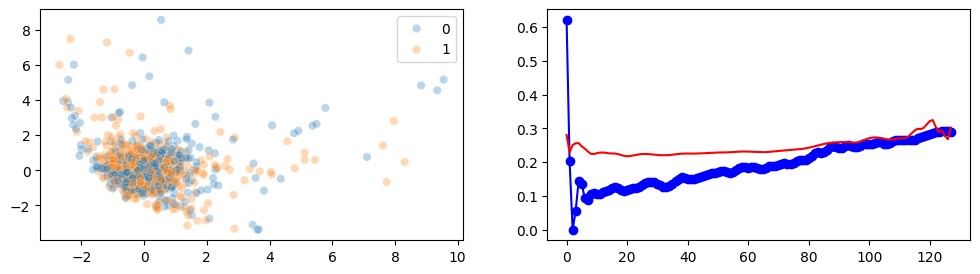

GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=10.0, class_weight='balanced', kernel='linear',
                     probability=True, random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.663+-0.061
roc_auc, 0.95% interval from cross-validation: 0.704+-0.049
accuracy, 0.95% interval from cross-validation: 0.659+-0.040
f1, 0.95% interval from cross-validation: 0.652+-0.038
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.665+-0.097
roc_auc, 0.95% interval from cross-validation: 0.699+-0.082
accuracy, 0.95% interval from cross-validation: 0.647+-0.081
f1, 0.95% interval from cross-validation: 0.638+-0.081
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=10.0, class_weight='balanced

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.007,0.993,0.807,16.800,0.007,0.005,0.006,0.012,0.082,0.663,0.061,0.704,0.049,0.659,0.040,0.652,0.038,0.665,0.097,0.699,0.082,0.647,0.081,0.638,0.081,0.670,0.719,0.669,0.652,0.626,0.711,0.676,0.704,0.623,0.597,0.546,0.703


##### Testing in test mode... #####
Epoch 50, step 0
Plotting PCA...


,Explained variance,Ratio
0,0.012522,0.391137
1,0.006846,0.213840


Plotting reconstruction...


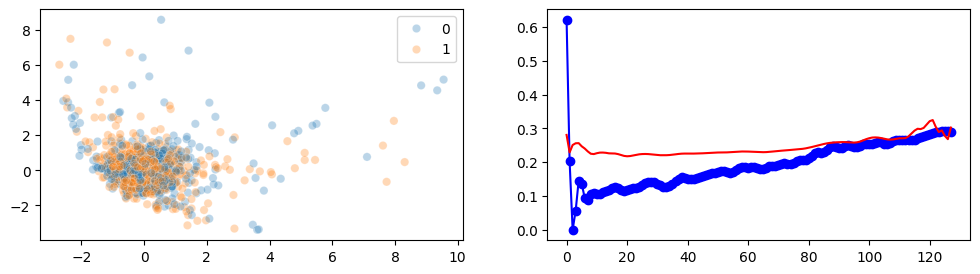

GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=10.0, class_weight='balanced', kernel='linear',
                     probability=True, random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.662+-0.074
roc_auc, 0.95% interval from cross-validation: 0.704+-0.071
accuracy, 0.95% interval from cross-validation: 0.653+-0.069
f1, 0.95% interval from cross-validation: 0.644+-0.073
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.665+-0.062
roc_auc, 0.95% interval from cross-validation: 0.703+-0.053
accuracy, 0.95% interval from cross-validation: 0.650+-0.050
f1, 0.95% interval from cross-validation: 0.641+-0.052
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=10.0, class_weight='balanced

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.007,0.993,0.807,16.800,0.007,0.005,0.006,0.012,0.082,0.662,0.074,0.704,0.071,0.653,0.069,0.644,0.073,0.665,0.062,0.703,0.053,0.650,0.050,0.641,0.052,0.696,0.736,0.687,0.674,0.647,0.727,0.638,0.673,0.611,0.605,0.592,0.631


#################### depr. anon., AE, 3 ch., 4/8/16/32, 7/7/5/3/3/3/3/1, Sigmoid, 2 s ####################
{
    "project_name": "EEG_depression_classification",
    "method": "direct restoration",
    "save_path": "model_weights/",
    "log_path": "logs/",
    "dataset": {
        "batch_size": 256,
        "num_workers": 0,
        "dataset": "depression_anonymized",
        "dataset_file": "Data/depression_anonymized/dataset_128_2.0.pkl",
        "val_size": 30,
        "test_size": 30
    },
    "model": {
        "model": "AE",
        "loss_reduction": "mean",
        "model_description": "depr. anon., AE, 3 ch., 4/8/16/32, 7/7/5/3/3/3/3/1, Sigmoid, 2 s"
    },
    "optimizer": {
        "optimizer": "AdamW",
        "kwargs": {
            "lr": 0.001
        }
    },
    "scheduler": {
        "scheduler": "ReduceLROnPlateau",
        "kwargs": {
            "factor": 0.5,
            "patience": 3,
            "verbose": true
        }
    },
    "train": {
        "loss_coefs

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5340/5340 [00:00<00:00, 35068.72it/s]


Train: 3540 (3, 256)
Validation: 900 (3, 256)
Test: 900 (3, 256)
model depr. anon., AE, 3 ch., 4/8/16/32, 7/7/5/3/3/3/3/1, Sigmoid, 2 s is created
Test data point shape: torch.Size([1, 3, 256])
Test inference: 1
Test reconstruct: torch.Size([1, 3, 256])
Test encode: torch.Size([1, 32, 32])
Optimizer AdamW is instantiated
Scheduler ReduceLROnPlateau is instantiated
Logging via WandB


  0%|                                                                                                                                   | 0/50 [00:00<?, ?it/s]

Epoch 0
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.418,0.582,0.380,0.808,0.418,0.006,0.007,0.006,0.646,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=10.0, class_weight='balanced', kernel='linear',
                     probability=True, random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.861+-0.059
roc_auc, 0.95% interval from cross-validation: 0.849+-0.079
accuracy, 0.95% interval from cross-validation: 0.776+-0.072
f1, 0.95% interval from cross-validation: 0.769+-0.076
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.869+-0.057
roc_auc, 0.95% interval from cross-validation: 0.855+-0.025
accuracy, 0.95% interval from cross-validation: 0.787+-0.045
f1, 0.95% interval from cross-validation: 0.781+-0.052
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=10

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.409,0.591,-0.001,0.671,0.409,0.005,0.004,0.006,0.640,0.861,0.059,0.849,0.079,0.776,0.072,0.769,0.076,0.869,0.057,0.855,0.025,0.787,0.045,0.781,0.052,0.896,0.871,0.811,0.811,0.792,0.831,0.818,0.836,0.771,0.766,0.782,0.761


  2%|██▍                                                                                                                     | 1/50 [02:37<2:08:37, 157.50s/it]

New best classifier accuracy = 0.7866666666666667 on epoch 0
Epoch 1
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.367,0.633,0.516,1.567,0.367,0.006,0.006,0.006,0.606,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=10.0, class_weight='balanced', kernel='linear',
                     probability=True, random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.852+-0.071
roc_auc, 0.95% interval from cross-validation: 0.833+-0.079
accuracy, 0.95% interval from cross-validation: 0.778+-0.088
f1, 0.95% interval from cross-validation: 0.773+-0.073
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.851+-0.086
roc_auc, 0.95% interval from cross-validation: 0.834+-0.085
accuracy, 0.95% interval from cross-validation: 0.770+-0.083
f1, 0.95% interval from cross-validation: 0.761+-0.094
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=10

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.366,0.634,0.004,1.039,0.366,0.005,0.004,0.006,0.605,0.852,0.071,0.833,0.079,0.778,0.088,0.773,0.073,0.851,0.086,0.834,0.085,0.770,0.083,0.761,0.094,0.877,0.859,0.816,0.810,0.782,0.850,0.848,0.838,0.768,0.747,0.694,0.840


  4%|████▊                                                                                                                   | 2/50 [05:10<2:03:42, 154.63s/it]

Epoch 2
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.326,0.674,0.555,2.205,0.326,0.006,0.006,0.006,0.571,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=10.0, class_weight='balanced', kernel='linear',
                     probability=True, random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.841+-0.060
roc_auc, 0.95% interval from cross-validation: 0.836+-0.089
accuracy, 0.95% interval from cross-validation: 0.764+-0.091
f1, 0.95% interval from cross-validation: 0.751+-0.106
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.841+-0.094
roc_auc, 0.95% interval from cross-validation: 0.833+-0.083
accuracy, 0.95% interval from cross-validation: 0.767+-0.080
f1, 0.95% interval from cross-validation: 0.754+-0.088
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=10

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.332,0.668,0.469,1.429,0.332,0.005,0.004,0.006,0.576,0.841,0.060,0.836,0.089,0.764,0.091,0.751,0.106,0.841,0.094,0.833,0.083,0.767,0.080,0.754,0.088,0.878,0.875,0.806,0.794,0.758,0.852,0.799,0.807,0.731,0.714,0.658,0.807


  6%|███████▏                                                                                                                | 3/50 [07:18<1:51:54, 142.87s/it]

Epoch 3
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.288,0.712,0.588,2.735,0.288,0.006,0.006,0.006,0.537,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=10.0, class_weight='balanced', kernel='linear',
                     probability=True, random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.822+-0.070
roc_auc, 0.95% interval from cross-validation: 0.822+-0.050
accuracy, 0.95% interval from cross-validation: 0.733+-0.047
f1, 0.95% interval from cross-validation: 0.724+-0.053
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.832+-0.095
roc_auc, 0.95% interval from cross-validation: 0.824+-0.074
accuracy, 0.95% interval from cross-validation: 0.733+-0.077
f1, 0.95% interval from cross-validation: 0.727+-0.059
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(clas

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.286,0.714,0.635,2.608,0.286,0.005,0.005,0.006,0.535,0.822,0.070,0.822,0.050,0.733,0.047,0.724,0.053,0.832,0.095,0.824,0.074,0.733,0.077,0.727,0.059,0.846,0.840,0.748,0.753,0.739,0.758,0.759,0.784,0.704,0.686,0.706,0.702


  8%|█████████▌                                                                                                              | 4/50 [08:53<1:34:49, 123.68s/it]

Epoch 4
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.254,0.746,0.622,3.293,0.254,0.006,0.006,0.006,0.504,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=10.0, class_weight='balanced', kernel='linear',
                     probability=True, random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.803+-0.044
roc_auc, 0.95% interval from cross-validation: 0.816+-0.057
accuracy, 0.95% interval from cross-validation: 0.752+-0.048
f1, 0.95% interval from cross-validation: 0.744+-0.051
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.812+-0.114
roc_auc, 0.95% interval from cross-validation: 0.812+-0.091
accuracy, 0.95% interval from cross-validation: 0.740+-0.081
f1, 0.95% interval from cross-validation: 0.735+-0.076
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=10

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.236,0.764,0.643,3.142,0.236,0.004,0.005,0.006,0.486,0.803,0.044,0.816,0.057,0.752,0.048,0.744,0.051,0.812,0.114,0.812,0.091,0.740,0.081,0.735,0.076,0.871,0.872,0.808,0.801,0.772,0.844,0.756,0.774,0.714,0.689,0.635,0.792


 10%|████████████                                                                                                            | 5/50 [10:05<1:18:45, 105.01s/it]

Epoch 5
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.224,0.776,0.643,3.773,0.224,0.006,0.006,0.007,0.473,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=10.0, class_weight='balanced', kernel='linear',
                     probability=True, random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.802+-0.113
roc_auc, 0.95% interval from cross-validation: 0.807+-0.088
accuracy, 0.95% interval from cross-validation: 0.738+-0.097
f1, 0.95% interval from cross-validation: 0.731+-0.096
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.810+-0.060
roc_auc, 0.95% interval from cross-validation: 0.815+-0.047
accuracy, 0.95% interval from cross-validation: 0.740+-0.055
f1, 0.95% interval from cross-validation: 0.732+-0.065
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=10

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.211,0.789,0.650,3.600,0.211,0.004,0.005,0.007,0.460,0.802,0.113,0.807,0.088,0.738,0.097,0.731,0.096,0.810,0.060,0.815,0.047,0.740,0.055,0.732,0.065,0.874,0.869,0.779,0.769,0.733,0.827,0.758,0.777,0.727,0.716,0.694,0.760


 12%|██████████████▌                                                                                                          | 6/50 [11:12<1:07:32, 92.11s/it]

Epoch 6
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.196,0.804,0.656,4.229,0.196,0.006,0.006,0.007,0.443,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=10.0, class_weight='balanced', kernel='linear',
                     probability=True, random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.791+-0.081
roc_auc, 0.95% interval from cross-validation: 0.797+-0.051
accuracy, 0.95% interval from cross-validation: 0.718+-0.047
f1, 0.95% interval from cross-validation: 0.705+-0.038
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.800+-0.129
roc_auc, 0.95% interval from cross-validation: 0.808+-0.104
accuracy, 0.95% interval from cross-validation: 0.729+-0.065
f1, 0.95% interval from cross-validation: 0.717+-0.072
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=10

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.178,0.822,0.667,4.427,0.178,0.004,0.004,0.007,0.422,0.791,0.081,0.797,0.051,0.718,0.047,0.705,0.038,0.800,0.129,0.808,0.104,0.729,0.065,0.717,0.072,0.857,0.849,0.765,0.755,0.713,0.818,0.792,0.784,0.694,0.674,0.657,0.727


 14%|█████████████████▏                                                                                                         | 7/50 [12:18<59:50, 83.50s/it]

Epoch 7
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.172,0.828,0.669,4.678,0.172,0.005,0.006,0.007,0.415,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=10.0, class_weight='balanced', kernel='linear',
                     probability=True, random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.784+-0.057
roc_auc, 0.95% interval from cross-validation: 0.799+-0.032
accuracy, 0.95% interval from cross-validation: 0.704+-0.061
f1, 0.95% interval from cross-validation: 0.687+-0.083
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.806+-0.107
roc_auc, 0.95% interval from cross-validation: 0.807+-0.085
accuracy, 0.95% interval from cross-validation: 0.714+-0.080
f1, 0.95% interval from cross-validation: 0.700+-0.092
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=10

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.160,0.840,0.672,4.893,0.160,0.004,0.004,0.006,0.400,0.784,0.057,0.799,0.032,0.704,0.061,0.687,0.083,0.806,0.107,0.807,0.085,0.714,0.080,0.700,0.092,0.819,0.830,0.736,0.731,0.706,0.768,0.791,0.814,0.727,0.714,0.701,0.752


 16%|███████████████████▋                                                                                                       | 8/50 [13:25<54:51, 78.38s/it]

Epoch 8
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.151,0.849,0.679,5.132,0.151,0.005,0.006,0.007,0.388,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=10.0, class_weight='balanced', kernel='linear',
                     probability=True, random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.805+-0.069
roc_auc, 0.95% interval from cross-validation: 0.808+-0.068
accuracy, 0.95% interval from cross-validation: 0.716+-0.068
f1, 0.95% interval from cross-validation: 0.699+-0.079
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.799+-0.114
roc_auc, 0.95% interval from cross-validation: 0.802+-0.087
accuracy, 0.95% interval from cross-validation: 0.699+-0.078
f1, 0.95% interval from cross-validation: 0.682+-0.082
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=10

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.139,0.861,0.677,5.373,0.139,0.004,0.004,0.006,0.373,0.805,0.069,0.808,0.068,0.716,0.068,0.699,0.079,0.799,0.114,0.802,0.087,0.699,0.078,0.682,0.082,0.840,0.847,0.748,0.729,0.687,0.807,0.849,0.826,0.737,0.717,0.647,0.833


 18%|██████████████████████▏                                                                                                    | 9/50 [14:32<51:09, 74.87s/it]

Epoch 9
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.132,0.868,0.686,5.587,0.132,0.005,0.006,0.007,0.363,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=10.0, class_weight='balanced', kernel='linear',
                     probability=True, random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.810+-0.064
roc_auc, 0.95% interval from cross-validation: 0.815+-0.063
accuracy, 0.95% interval from cross-validation: 0.728+-0.050
f1, 0.95% interval from cross-validation: 0.708+-0.076
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.820+-0.069
roc_auc, 0.95% interval from cross-validation: 0.817+-0.044
accuracy, 0.95% interval from cross-validation: 0.724+-0.044
f1, 0.95% interval from cross-validation: 0.708+-0.041
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(clas

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.123,0.877,0.675,5.776,0.123,0.004,0.005,0.006,0.350,0.810,0.064,0.815,0.063,0.728,0.050,0.708,0.076,0.820,0.069,0.817,0.044,0.724,0.044,0.708,0.041,0.822,0.816,0.736,0.725,0.684,0.791,0.750,0.771,0.694,0.674,0.657,0.727


 20%|████████████████████████▍                                                                                                 | 10/50 [15:42<48:51, 73.28s/it]

Epoch 10
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.115,0.885,0.692,6.050,0.115,0.005,0.006,0.006,0.339,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=10.0, class_weight='balanced', kernel='linear',
                     probability=True, random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.795+-0.074
roc_auc, 0.95% interval from cross-validation: 0.805+-0.045
accuracy, 0.95% interval from cross-validation: 0.722+-0.041
f1, 0.95% interval from cross-validation: 0.703+-0.047
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.813+-0.129
roc_auc, 0.95% interval from cross-validation: 0.815+-0.092
accuracy, 0.95% interval from cross-validation: 0.723+-0.077
f1, 0.95% interval from cross-validation: 0.704+-0.085
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=0.

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.107,0.893,0.699,6.195,0.107,0.004,0.004,0.006,0.327,0.795,0.074,0.805,0.045,0.722,0.041,0.703,0.047,0.813,0.129,0.815,0.092,0.723,0.077,0.704,0.085,0.791,0.794,0.728,0.727,0.703,0.754,0.685,0.694,0.673,0.625,0.579,0.758


 22%|██████████████████████████▊                                                                                               | 11/50 [16:56<47:54, 73.69s/it]

Epoch 11
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.100,0.900,0.698,6.506,0.100,0.005,0.006,0.006,0.316,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=10.0, class_weight='balanced', kernel='linear',
                     probability=True, random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.794+-0.092
roc_auc, 0.95% interval from cross-validation: 0.803+-0.078
accuracy, 0.95% interval from cross-validation: 0.703+-0.067
f1, 0.95% interval from cross-validation: 0.676+-0.085
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.804+-0.105
roc_auc, 0.95% interval from cross-validation: 0.811+-0.066
accuracy, 0.95% interval from cross-validation: 0.713+-0.090
f1, 0.95% interval from cross-validation: 0.689+-0.119
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(clas

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.094,0.906,0.692,6.652,0.094,0.004,0.004,0.006,0.306,0.794,0.092,0.803,0.078,0.703,0.067,0.676,0.085,0.804,0.105,0.811,0.066,0.713,0.090,0.689,0.119,0.826,0.817,0.726,0.720,0.691,0.764,0.754,0.781,0.717,0.689,0.650,0.779


 24%|█████████████████████████████▎                                                                                            | 12/50 [18:09<46:24, 73.27s/it]

Epoch 12
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.087,0.913,0.703,6.983,0.087,0.005,0.006,0.006,0.295,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=10.0, class_weight='balanced', kernel='linear',
                     probability=True, random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.796+-0.066
roc_auc, 0.95% interval from cross-validation: 0.802+-0.061
accuracy, 0.95% interval from cross-validation: 0.707+-0.064
f1, 0.95% interval from cross-validation: 0.688+-0.071
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.806+-0.088
roc_auc, 0.95% interval from cross-validation: 0.813+-0.069
accuracy, 0.95% interval from cross-validation: 0.727+-0.095
f1, 0.95% interval from cross-validation: 0.705+-0.112
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=10

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.079,0.921,0.702,7.263,0.079,0.004,0.004,0.006,0.282,0.796,0.066,0.802,0.061,0.707,0.064,0.688,0.071,0.806,0.088,0.813,0.069,0.727,0.095,0.705,0.112,0.859,0.854,0.756,0.755,0.736,0.777,0.758,0.803,0.710,0.686,0.657,0.760


 26%|███████████████████████████████▋                                                                                          | 13/50 [19:25<45:45, 74.21s/it]

Epoch 13
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.075,0.925,0.708,7.460,0.075,0.005,0.006,0.006,0.274,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=10.0, class_weight='balanced', kernel='linear',
                     probability=True, random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.796+-0.056
roc_auc, 0.95% interval from cross-validation: 0.807+-0.033
accuracy, 0.95% interval from cross-validation: 0.720+-0.046
f1, 0.95% interval from cross-validation: 0.706+-0.065
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.798+-0.101
roc_auc, 0.95% interval from cross-validation: 0.806+-0.075
accuracy, 0.95% interval from cross-validation: 0.721+-0.078
f1, 0.95% interval from cross-validation: 0.705+-0.105
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=10

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.070,0.930,0.710,7.664,0.070,0.004,0.004,0.006,0.265,0.796,0.056,0.807,0.033,0.720,0.046,0.706,0.065,0.798,0.101,0.806,0.075,0.721,0.078,0.705,0.105,0.852,0.852,0.750,0.733,0.697,0.801,0.789,0.793,0.704,0.690,0.641,0.771


 28%|██████████████████████████████████▏                                                                                       | 14/50 [20:40<44:38, 74.39s/it]

Epoch 14
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.065,0.935,0.712,7.938,0.065,0.005,0.006,0.006,0.256,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=0.1, class_weight='balanced', kernel='linear',
                     probability=True, random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.765+-0.065
roc_auc, 0.95% interval from cross-validation: 0.762+-0.022
accuracy, 0.95% interval from cross-validation: 0.709+-0.020
f1, 0.95% interval from cross-validation: 0.687+-0.027
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.782+-0.105
roc_auc, 0.95% interval from cross-validation: 0.766+-0.067
accuracy, 0.95% interval from cross-validation: 0.707+-0.059
f1, 0.95% interval from cross-validation: 0.683+-0.056
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=0.1

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.057,0.943,0.715,8.283,0.057,0.004,0.004,0.006,0.240,0.765,0.065,0.762,0.022,0.709,0.020,0.687,0.027,0.782,0.105,0.766,0.067,0.707,0.059,0.683,0.056,0.768,0.763,0.701,0.694,0.671,0.732,0.778,0.783,0.721,0.707,0.685,0.755


 30%|████████████████████████████████████▌                                                                                     | 15/50 [20:55<32:54, 56.42s/it]

Epoch 15
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.057,0.943,0.715,8.413,0.057,0.005,0.006,0.006,0.238,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=10.0, class_weight='balanced', kernel='linear',
                     probability=True, random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.794+-0.050
roc_auc, 0.95% interval from cross-validation: 0.797+-0.054
accuracy, 0.95% interval from cross-validation: 0.713+-0.064
f1, 0.95% interval from cross-validation: 0.695+-0.113
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.800+-0.098
roc_auc, 0.95% interval from cross-validation: 0.795+-0.067
accuracy, 0.95% interval from cross-validation: 0.703+-0.075
f1, 0.95% interval from cross-validation: 0.692+-0.076
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=10

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.048,0.952,0.713,8.857,0.048,0.004,0.004,0.006,0.220,0.794,0.050,0.797,0.054,0.713,0.064,0.695,0.113,0.800,0.098,0.795,0.067,0.703,0.075,0.692,0.076,0.852,0.853,0.760,0.749,0.711,0.809,0.747,0.786,0.697,0.681,0.658,0.735


 32%|███████████████████████████████████████                                                                                   | 16/50 [22:11<35:21, 62.40s/it]

Epoch 16
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.049,0.951,0.719,8.889,0.049,0.005,0.006,0.006,0.222,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(class_weight='balanced', kernel='linear', probability=True,
                     random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.802+-0.065
roc_auc, 0.95% interval from cross-validation: 0.796+-0.031
accuracy, 0.95% interval from cross-validation: 0.722+-0.044
f1, 0.95% interval from cross-validation: 0.703+-0.055
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.806+-0.145
roc_auc, 0.95% interval from cross-validation: 0.796+-0.115
accuracy, 0.95% interval from cross-validation: 0.721+-0.088
f1, 0.95% interval from cross-validation: 0.705+-0.092
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=0.1, class

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.041,0.959,0.720,9.401,0.041,0.004,0.004,0.006,0.203,0.802,0.065,0.796,0.031,0.722,0.044,0.703,0.055,0.806,0.145,0.796,0.115,0.721,0.088,0.705,0.092,0.779,0.776,0.718,0.706,0.669,0.768,0.785,0.779,0.717,0.700,0.676,0.757


 34%|█████████████████████████████████████████▍                                                                                | 17/50 [22:31<27:22, 49.79s/it]

Epoch 17
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.043,0.957,0.721,9.345,0.043,0.005,0.006,0.006,0.207,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=0.1, class_weight='balanced', kernel='linear',
                     probability=True, random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.781+-0.034
roc_auc, 0.95% interval from cross-validation: 0.773+-0.016
accuracy, 0.95% interval from cross-validation: 0.724+-0.051
f1, 0.95% interval from cross-validation: 0.707+-0.054
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.789+-0.102
roc_auc, 0.95% interval from cross-validation: 0.776+-0.098
accuracy, 0.95% interval from cross-validation: 0.723+-0.116
f1, 0.95% interval from cross-validation: 0.704+-0.135
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=10.

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.043,0.957,0.716,9.262,0.043,0.004,0.004,0.006,0.208,0.781,0.034,0.773,0.016,0.724,0.051,0.707,0.054,0.789,0.102,0.776,0.098,0.723,0.116,0.704,0.135,0.832,0.837,0.760,0.735,0.686,0.829,0.821,0.801,0.721,0.713,0.656,0.793


 36%|███████████████████████████████████████████▉                                                                              | 18/50 [22:46<20:58, 39.31s/it]

Epoch 18
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.037,0.963,0.724,9.806,0.037,0.005,0.006,0.006,0.194,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=0.1, class_weight='balanced', kernel='linear',
                     probability=True, random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.785+-0.062
roc_auc, 0.95% interval from cross-validation: 0.779+-0.026
accuracy, 0.95% interval from cross-validation: 0.719+-0.036
f1, 0.95% interval from cross-validation: 0.707+-0.037
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.788+-0.093
roc_auc, 0.95% interval from cross-validation: 0.779+-0.093
accuracy, 0.95% interval from cross-validation: 0.716+-0.108
f1, 0.95% interval from cross-validation: 0.701+-0.120
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(class

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.034,0.966,0.723,9.977,0.034,0.004,0.004,0.006,0.185,0.785,0.062,0.779,0.026,0.719,0.036,0.707,0.037,0.788,0.093,0.779,0.093,0.716,0.108,0.701,0.120,0.857,0.842,0.761,0.745,0.700,0.822,0.714,0.732,0.673,0.678,0.680,0.667


 38%|██████████████████████████████████████████████▎                                                                           | 19/50 [23:01<16:27, 31.86s/it]

Epoch 19
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.033,0.967,0.727,10.245,0.033,0.005,0.006,0.006,0.181,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(class_weight='balanced', kernel='linear', probability=True,
                     random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.789+-0.048
roc_auc, 0.95% interval from cross-validation: 0.791+-0.033
accuracy, 0.95% interval from cross-validation: 0.709+-0.043
f1, 0.95% interval from cross-validation: 0.697+-0.055
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.800+-0.096
roc_auc, 0.95% interval from cross-validation: 0.790+-0.081
accuracy, 0.95% interval from cross-validation: 0.701+-0.084
f1, 0.95% interval from cross-validation: 0.688+-0.085
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=0.1, class

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.032,0.968,0.727,10.262,0.032,0.004,0.004,0.006,0.179,0.789,0.048,0.791,0.033,0.709,0.043,0.697,0.055,0.800,0.096,0.790,0.081,0.701,0.084,0.688,0.085,0.765,0.768,0.706,0.696,0.672,0.741,0.826,0.826,0.751,0.743,0.723,0.779


 40%|████████████████████████████████████████████████▊                                                                         | 20/50 [23:21<14:09, 28.31s/it]

Epoch 20
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.029,0.971,0.729,10.667,0.029,0.005,0.006,0.006,0.170,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(class_weight='balanced', kernel='linear', probability=True,
                     random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.796+-0.103
roc_auc, 0.95% interval from cross-validation: 0.791+-0.077
accuracy, 0.95% interval from cross-validation: 0.712+-0.071
f1, 0.95% interval from cross-validation: 0.700+-0.062
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.808+-0.114
roc_auc, 0.95% interval from cross-validation: 0.795+-0.104
accuracy, 0.95% interval from cross-validation: 0.710+-0.092
f1, 0.95% interval from cross-validation: 0.699+-0.096
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(class_weight

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.027,0.973,0.727,10.830,0.027,0.004,0.004,0.006,0.165,0.796,0.103,0.791,0.077,0.712,0.071,0.700,0.062,0.808,0.114,0.795,0.104,0.710,0.092,0.699,0.096,0.825,0.810,0.741,0.743,0.739,0.744,0.802,0.814,0.710,0.709,0.729,0.693


 42%|███████████████████████████████████████████████████▏                                                                      | 21/50 [23:41<12:28, 25.80s/it]

Epoch 21
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.026,0.974,0.731,11.068,0.026,0.005,0.006,0.006,0.161,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=0.1, class_weight='balanced', kernel='linear',
                     probability=True, random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.783+-0.061
roc_auc, 0.95% interval from cross-validation: 0.773+-0.056
accuracy, 0.95% interval from cross-validation: 0.713+-0.041
f1, 0.95% interval from cross-validation: 0.698+-0.040
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.791+-0.120
roc_auc, 0.95% interval from cross-validation: 0.781+-0.094
accuracy, 0.95% interval from cross-validation: 0.716+-0.089
f1, 0.95% interval from cross-validation: 0.698+-0.119
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(class

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.025,0.975,0.731,11.141,0.025,0.004,0.004,0.006,0.158,0.783,0.061,0.773,0.056,0.713,0.041,0.698,0.040,0.791,0.120,0.781,0.094,0.716,0.089,0.698,0.119,0.823,0.819,0.736,0.723,0.688,0.785,0.798,0.780,0.721,0.707,0.671,0.770


 44%|█████████████████████████████████████████████████████▋                                                                    | 22/50 [23:55<10:24, 22.29s/it]

Epoch 22
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.023,0.977,0.733,11.457,0.023,0.005,0.005,0.006,0.152,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=0.1, class_weight='balanced', kernel='linear',
                     probability=True, random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.767+-0.078
roc_auc, 0.95% interval from cross-validation: 0.767+-0.065
accuracy, 0.95% interval from cross-validation: 0.709+-0.055
f1, 0.95% interval from cross-validation: 0.692+-0.071
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.782+-0.073
roc_auc, 0.95% interval from cross-validation: 0.775+-0.064
accuracy, 0.95% interval from cross-validation: 0.707+-0.062
f1, 0.95% interval from cross-validation: 0.692+-0.085
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=0.1

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.022,0.978,0.735,11.622,0.022,0.004,0.004,0.006,0.147,0.767,0.078,0.767,0.065,0.709,0.055,0.692,0.071,0.782,0.073,0.775,0.064,0.707,0.062,0.692,0.085,0.781,0.774,0.720,0.703,0.662,0.777,0.734,0.787,0.731,0.722,0.703,0.758


 46%|████████████████████████████████████████████████████████                                                                  | 23/50 [24:09<08:52, 19.72s/it]

Epoch 23
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.021,0.979,0.734,11.804,0.021,0.005,0.005,0.006,0.145,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=10.0, class_weight='balanced', kernel='linear',
                     probability=True, random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.784+-0.038
roc_auc, 0.95% interval from cross-validation: 0.791+-0.054
accuracy, 0.95% interval from cross-validation: 0.721+-0.070
f1, 0.95% interval from cross-validation: 0.707+-0.059
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.795+-0.127
roc_auc, 0.95% interval from cross-validation: 0.789+-0.127
accuracy, 0.95% interval from cross-validation: 0.704+-0.114
f1, 0.95% interval from cross-validation: 0.689+-0.115
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=10

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.020,0.980,0.735,11.909,0.020,0.004,0.004,0.006,0.141,0.784,0.038,0.791,0.054,0.721,0.070,0.707,0.059,0.795,0.127,0.789,0.127,0.704,0.114,0.689,0.115,0.847,0.847,0.756,0.752,0.726,0.787,0.781,0.777,0.690,0.657,0.615,0.760


 48%|██████████████████████████████████████████████████████████▌                                                               | 24/50 [25:26<16:00, 36.95s/it]

Epoch 24
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.019,0.981,0.738,12.137,0.019,0.005,0.005,0.006,0.138,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(class_weight='balanced', kernel='linear', probability=True,
                     random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.793+-0.086
roc_auc, 0.95% interval from cross-validation: 0.786+-0.088
accuracy, 0.95% interval from cross-validation: 0.714+-0.067
f1, 0.95% interval from cross-validation: 0.696+-0.073
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.787+-0.071
roc_auc, 0.95% interval from cross-validation: 0.788+-0.097
accuracy, 0.95% interval from cross-validation: 0.709+-0.097
f1, 0.95% interval from cross-validation: 0.691+-0.104
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(class_weight

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.019,0.981,0.737,12.104,0.019,0.004,0.004,0.006,0.137,0.793,0.086,0.786,0.088,0.714,0.067,0.696,0.073,0.787,0.071,0.788,0.097,0.709,0.097,0.691,0.104,0.837,0.820,0.728,0.707,0.662,0.793,0.753,0.777,0.707,0.693,0.649,0.767


 50%|█████████████████████████████████████████████████████████████                                                             | 25/50 [25:45<13:13, 31.73s/it]

Epoch 25
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.018,0.982,0.739,12.449,0.018,0.005,0.005,0.006,0.133,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=10.0, class_weight='balanced', kernel='linear',
                     probability=True, random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.789+-0.023
roc_auc, 0.95% interval from cross-validation: 0.794+-0.034
accuracy, 0.95% interval from cross-validation: 0.722+-0.036
f1, 0.95% interval from cross-validation: 0.707+-0.032
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.798+-0.130
roc_auc, 0.95% interval from cross-validation: 0.797+-0.114
accuracy, 0.95% interval from cross-validation: 0.721+-0.098
f1, 0.95% interval from cross-validation: 0.701+-0.120
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=0.

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.016,0.984,0.743,12.745,0.016,0.004,0.004,0.006,0.128,0.789,0.023,0.794,0.034,0.722,0.036,0.707,0.032,0.798,0.130,0.797,0.114,0.721,0.098,0.701,0.120,0.776,0.773,0.710,0.705,0.685,0.735,0.800,0.797,0.727,0.722,0.724,0.730


 52%|███████████████████████████████████████████████████████████████▍                                                          | 26/50 [27:01<17:59, 44.96s/it]

Epoch 26
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.016,0.984,0.741,12.744,0.016,0.005,0.005,0.006,0.128,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(class_weight='balanced', kernel='linear', probability=True,
                     random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.781+-0.105
roc_auc, 0.95% interval from cross-validation: 0.783+-0.076
accuracy, 0.95% interval from cross-validation: 0.717+-0.070
f1, 0.95% interval from cross-validation: 0.700+-0.058
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.791+-0.061
roc_auc, 0.95% interval from cross-validation: 0.788+-0.054
accuracy, 0.95% interval from cross-validation: 0.720+-0.055
f1, 0.95% interval from cross-validation: 0.698+-0.085
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(class_weight

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.016,0.984,0.744,12.899,0.016,0.004,0.004,0.006,0.125,0.781,0.105,0.783,0.076,0.717,0.070,0.700,0.058,0.791,0.061,0.788,0.054,0.720,0.055,0.698,0.085,0.833,0.813,0.728,0.719,0.675,0.784,0.738,0.785,0.724,0.685,0.640,0.797


 54%|█████████████████████████████████████████████████████████████████▉                                                        | 27/50 [27:21<14:22, 37.49s/it]

Epoch 27
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.015,0.985,0.743,12.988,0.015,0.005,0.005,0.006,0.124,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=10.0, class_weight='balanced', kernel='linear',
                     probability=True, random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.775+-0.068
roc_auc, 0.95% interval from cross-validation: 0.789+-0.052
accuracy, 0.95% interval from cross-validation: 0.717+-0.048
f1, 0.95% interval from cross-validation: 0.695+-0.067
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.799+-0.108
roc_auc, 0.95% interval from cross-validation: 0.797+-0.070
accuracy, 0.95% interval from cross-validation: 0.717+-0.081
f1, 0.95% interval from cross-validation: 0.692+-0.118
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(clas

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.015,0.985,0.748,13.126,0.015,0.004,0.004,0.006,0.122,0.775,0.068,0.789,0.052,0.717,0.048,0.695,0.067,0.799,0.108,0.797,0.070,0.717,0.081,0.692,0.118,0.838,0.823,0.761,0.749,0.703,0.822,0.743,0.768,0.714,0.686,0.646,0.778


 56%|████████████████████████████████████████████████████████████████████▎                                                     | 28/50 [28:41<18:21, 50.09s/it]

Epoch 28
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.015,0.985,0.744,13.186,0.015,0.005,0.005,0.006,0.121,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(class_weight='balanced', kernel='linear', probability=True,
                     random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.780+-0.096
roc_auc, 0.95% interval from cross-validation: 0.786+-0.048
accuracy, 0.95% interval from cross-validation: 0.727+-0.047
f1, 0.95% interval from cross-validation: 0.703+-0.052
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.785+-0.082
roc_auc, 0.95% interval from cross-validation: 0.782+-0.114
accuracy, 0.95% interval from cross-validation: 0.720+-0.101
f1, 0.95% interval from cross-validation: 0.695+-0.120
Data split
GridSearchCV
Best classifier: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=0.1, class

,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,clf.cv.train.average_precision.cv,clf.cv.train.average_precision.se.cv,clf.cv.train.roc_auc.cv,clf.cv.train.roc_auc.se.cv,clf.cv.train.accuracy.cv,clf.cv.train.accuracy.se.cv,clf.cv.train.f1.cv,clf.cv.train.f1.se.cv,clf.cv.test.average_precision.cv,clf.cv.test.average_precision.se.cv,clf.cv.test.roc_auc.cv,clf.cv.test.roc_auc.se.cv,clf.cv.test.accuracy.cv,clf.cv.test.accuracy.se.cv,clf.cv.test.f1.cv,clf.cv.test.f1.se.cv,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.sensitivity,clf.d.test.specificity
0,0.015,0.985,0.741,12.953,0.015,0.004,0.004,0.006,0.123,0.780,0.096,0.786,0.048,0.727,0.047,0.703,0.052,0.785,0.082,0.782,0.114,0.720,0.101,0.695,0.120,0.768,0.762,0.701,0.698,0.671,0.734,0.771,0.777,0.690,0.674,0.679,0.701


 58%|██████████████████████████████████████████████████████████████████████▊                                                   | 29/50 [29:02<14:27, 41.29s/it]

Epoch 29
##### Training... #####


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,lr
0,0.014,0.986,0.748,13.424,0.014,0.005,0.005,0.006,0.118,0.001


##### Validation... #####
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=10.0, class_weight='balanced', kernel='linear',
                     probability=True, random_state=42))])
Evaluation on the train data
average_precision, 0.95% interval from cross-validation: 0.784+-0.098
roc_auc, 0.95% interval from cross-validation: 0.787+-0.068
accuracy, 0.95% interval from cross-validation: 0.719+-0.055
f1, 0.95% interval from cross-validation: 0.697+-0.067
Evaluation on the test data
average_precision, 0.95% interval from cross-validation: 0.795+-0.128
roc_auc, 0.95% interval from cross-validation: 0.794+-0.100
accuracy, 0.95% interval from cross-validation: 0.709+-0.083


In [ ]:
all_results = []
for config in experiments:
    all_results.append(train(config, verbose=2))